## Importation des données, passer directement à Using CollocatedCokriging workflow 

In [2]:
#Recupere les noms des IR dans le dossier path, 
#par defaut = './traitement_PIREN/' et permet de 
#choisir n'importe quelle ortho avec son nom 

filetif = ['6H55','7H29','8H22','9H28','10H22','11H27','12H31','13H26',
                               '15H59','17H27']
 
ls_path_tif,filetif = get_tif(filetif)
dict_IR= alternative_readingIR_all(ls_path_tif,filetif)

completed : IR_6H55
completed : IR_7H29
completed : IR_8H22
completed : IR_9H28
completed : IR_10H22
completed : IR_11H27
completed : IR_12H31
completed : IR_13H26
completed : IR_15H59
completed : IR_17H27


# Fenêtrage des sondes, création de Dict_IR

In [3]:
from rasterio.windows import Window
def reading_1band(LONGUEUR,filetif,ls_path_tif,normalization = True) :
    """ Lit un fichier .tif à 1 band et retourne un patch carré de coté LONGUEUR au format DataFrame [x,y,band 1]
    """
    
    #filename = './traitement_PIREN/vis_piren_phase_HSV.tif'
    #LONGUEUR = 10
    filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
    sensor_coord = reading_gps_file(filename_Sensor_txt)
    dict_IR = {} # va contenir les noms IR + tous les dicts associés à chaque sonde
    
    for m,tif in enumerate(ls_path_tif) : 
        with rio.open(tif) as dataset :
            #Value par défaut
            #win_height = 6303
            #win_width = 3421
            

            ls_index_target = [] # liste des valeurs indexées dans l'image
            win_height = round(LONGUEUR / dataset.res[0])
            win_width  = round(LONGUEUR / dataset.res[1])
            print("Taille de la fenetre :",win_height,"x",win_width)
            print("Résolution ","x:",dataset.res[0],"y:",dataset.res[1])

            # Loop pour recuperer les coordonnées UTM et convertir en indice 
            for k in range(len(sensor_coord["SensorName"])) :
                x = sensor_coord["x"][k] 
                y = sensor_coord["y"][k]
                target = dataset.index(float(x),float(y))
                ls_index_target.append(target)

            dict_windows = {} # liste des paramètres dans la création d'une window
            dict_windows_param = {} # dict des targets : améliore la lisibilité

            for i,index_target in enumerate(ls_index_target) :
                win = Window.from_slices((index_target[0]-(win_height//2),(index_target[0]+(win_height//2))),
                                         (index_target[1]-(win_width//2),(index_target[1]+(win_width//2)))
                                         )
                win_transform = dataset.window_transform(win)
                all_band = dataset.read(1,window = win) # en cas de visualisation

                dict_param = {"win" : win,
                                "win_transform" : win_transform,
                               "all_band" : all_band,
                               "SensorName" : sensor_coord["SensorName"][i],
                             "LONGUEUR" : LONGUEUR,
                             "resolution" : dataset.res}

                dict_windows_param[sensor_coord["SensorName"][i]] = dict_param

                # Vecteurs linéaires avec valeurs uniforméments crées
                x_start = win_transform[2]
                x_res   = win_transform[0]
                x_end   = x_start+(float(x_res)*win.width)

                y_end   = win_transform[5]
                y_res   = win_transform[4]
                y_start = y_end + (float(y_res)*win.height)

                #print("x_end =",x_end)
                #print("y_start =",y_start)

                x = np.linspace(x_start,x_end,num = win.width)
                y = np.linspace(y_start,y_end,num = win.height)

                band_1 = []
                x_matrix = []
                y_matrix = []
                # Loop pour obtenir la valeur de chaque pt pour chaque band
                if normalization == False :
                    for j in range(len(x)) :
                        for l in range(len(y)) :
                            for val in dataset.sample([(x[j],y[l])]): 
                                band_1.append(val[0])
                                x_matrix.append(x[j]) # permet de répeter le terme 
                                y_matrix.append(y[l])
                                mapping = ['x','y','band 1']
                    DATA_WINDOW = pd.DataFrame(np.array([x_matrix,
                                                         y_matrix,
                                                         band_1],dtype = object).T,
                                               columns=mapping)

                else :
                    for j in range(len(x)) :
                        for l in range(len(y)) :
                            for val in dataset.sample([(x[j],y[l])]): 
                                band_1.append(val[0])
                                x_matrix.append(x[j]) # permet de répeter le terme 
                                y_matrix.append(y[l])

                    mapping = ['x','y','band 1']
                    DATA_WINDOW = pd.DataFrame(np.array([x_matrix,
                                                         y_matrix,
                                                         band_1],dtype = object).T,
                                               columns=mapping)

                DATA_WINDOW['SensorName'] = sensor_coord["SensorName"][i]

                dict_windows[sensor_coord["SensorName"][i]] = DATA_WINDOW
        dict_IR["IR_"+filetif[m]] = {"dict_windows" : dict_windows,
                                     "dict_windows_param" : dict_windows_param}
        print("complited : ","IR_"+filetif[m])

            
    return dict_IR  

# Création de Dict_sensor

### Normalisation des données par ajout de bande à un DataFrame par Sonde/IR

In [4]:
def sensor_to_DataFrame(dict_IR):
    """
    Création d'un DataFrame par sonde contenant les positions et les des bandes normalisées, réunit sous 
    un dictionnaire
    """
    S1 = pd.DataFrame(columns = ["x","y","origin band","band 1","band N","IR"], dtype = float)
    S2 = pd.DataFrame(columns = ["x","y","origin band","band 1","band N","IR"], dtype = float)
    S3_AIR = pd.DataFrame(columns = ["x","y","origin band","band 1","band N","IR"], dtype = float)
    S4 = pd.DataFrame(columns = ["x","y","origin band","band 1","band N","IR"], dtype = float)
    S5 = pd.DataFrame(columns = ["x","y","origin band","band 1","band N","IR"], dtype = float)
    S6 = pd.DataFrame(columns = ["x","y","origin band","band 1","band N","IR"], dtype = float)
    S7 = pd.DataFrame(columns = ["x","y","origin band","band 1","band N","IR"], dtype = float)
    S8 = pd.DataFrame(columns = ["x","y","origin band","band 1","band N","IR"], dtype = float)
    S9 = pd.DataFrame(columns = ["x","y","origin band","band 1","band N","IR"], dtype = float)
    S10 = pd.DataFrame(columns = ["x","y","origin band","band 1","band N","IR"], dtype = float)
    dict_sensor = {"S1" : S1,"S2" : S2,"S3-AIR" : S3_AIR,"S4" : S4,"S5" : S5,
                "S6" : S6,"S7" : S7,"S8" : S8,"S9" : S9,"S10" : S10}



    for sensor in dict_sensor :
        k = 0
        BAND_MIN_N = 0
        BAND_MAX_N = 0
        for target in dict_IR :
            min_= dict_IR[target]["dict_windows"][sensor]["band 1"].min()
            max_= dict_IR[target]["dict_windows"][sensor]["band 1"].max()
            if min_ < BAND_MIN_N :
                BAND_MIN_N = min_


            if max_ > BAND_MAX_N :
                BAND_MAX_N = max_


        print("BAND_MIN_N",BAND_MIN_N) # valeur minimale retenue pour la normalisation
        print("BAND_MAX_N",BAND_MAX_N) # valeur maximale retenue pour la normalisation

        for target in dict_IR :

            band_shape = dict_IR[target]["dict_windows"][sensor][["band 1"]].shape[0]

            band_min = dict_IR[target]["dict_windows"][sensor]["band 1"].min()
            band_max = dict_IR[target]["dict_windows"][sensor]["band 1"].max()

            x = pd.DataFrame(dict_IR[target]["dict_windows"][sensor]["x"], dtype = float)
            y = pd.DataFrame(dict_IR[target]["dict_windows"][sensor]["y"], dtype = float)
            # band originale, sans normalisation
            origin_band = pd.DataFrame(dict_IR[target]["dict_windows"][sensor]["band 1"], dtype = float)
            origin_band.columns = ["origin band"]

            # band avec normalisation différente pour chaque IR
            band     = pd.DataFrame((dict_IR[target]["dict_windows"][sensor][["band 1"]]-band_min)/(band_max-band_min), dtype = float)

            # band avec normalisation commune pour chaque IR
            band_N   = pd.DataFrame((dict_IR[target]["dict_windows"][sensor][["band 1"]]-BAND_MIN_N)/(BAND_MAX_N-BAND_MIN_N), dtype = float) 
            band_N.columns = ['band N']

            # Concaténation de plusieurs bandes
            cnte = pd.concat([x,y,origin_band,band,band_N],axis=1)
            dict_sensor[sensor]=dict_sensor[sensor].append(cnte,ignore_index=True)

            # Repetition du nom de IR pour chaque valeurs -> boxplot
            dict_sensor[sensor]["IR"][k:(k+band_shape)]  = target

            k+=band_shape
        print("completed :",sensor)
    return dict_sensor


In [5]:
filetif = ['6H55','7H29','8H22','9H28','10H22','11H27','12H31','13H26',
                               '15H59','17H27']
ls_path_tif,filetif = get_tif(filetif)
Dimension = 4 # en m
dict_IR = reading_1band(Dimension,filetif,ls_path_tif,False)
dict_sensor = sensor_to_DataFrame(dict_IR)

Taille de la fenetre : 76 x 76
Résolution  x: 0.05292600000000282 y: 0.052925999999998544
complited :  IR_6H55
Taille de la fenetre : 80 x 80
Résolution  x: 0.050153899999997135 y: 0.050153899999983986
complited :  IR_7H29
Taille de la fenetre : 79 x 79
Résolution  x: 0.05041850000000147 y: 0.050418499999978765
complited :  IR_8H22
Taille de la fenetre : 78 x 78
Résolution  x: 0.051282600000007304 y: 0.051282600000011766
complited :  IR_9H28
Taille de la fenetre : 80 x 80
Résolution  x: 0.050209199999999767 y: 0.05020920000007991
complited :  IR_10H22
Taille de la fenetre : 76 x 76
Résolution  x: 0.05236010000000055 y: 0.05236010000001453
complited :  IR_11H27
Taille de la fenetre : 77 x 77
Résolution  x: 0.052141900000002274 y: 0.05214189999992463
complited :  IR_12H31
Taille de la fenetre : 76 x 76
Résolution  x: 0.05233229999999865 y: 0.05233229999999056
complited :  IR_13H26
Taille de la fenetre : 74 x 74
Résolution  x: 0.05439239999999872 y: 0.05439239999997738
complited :  IR_15H

<ipython-input-4-273d5e0b02d4>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_sensor[sensor]["IR"][k:(k+band_shape)]  = target


completed : S1
BAND_MIN_N -32.917344168417955
BAND_MAX_N 38.40395661744361
completed : S2
BAND_MIN_N -3.3359831748822186
BAND_MAX_N 31.3738075988364
completed : S3-AIR
BAND_MIN_N -23.571809587408183
BAND_MAX_N 29.900049305327542
completed : S4
BAND_MIN_N -41.13449950867384
BAND_MAX_N 25.930399399273597
completed : S5
BAND_MIN_N -20.725012288593927
BAND_MAX_N 44.7692651160593
completed : S6
BAND_MIN_N -32.91750079042471
BAND_MAX_N 33.45950911276358
completed : S7
BAND_MIN_N -4.073955516412584
BAND_MAX_N 29.07539627466459
completed : S8
BAND_MIN_N -33.178190071940435
BAND_MAX_N 37.719418600541886
completed : S9
BAND_MIN_N -3.280844727192102
BAND_MAX_N 34.268667440425425
completed : S10


## Moyenne entre deux rayon de cercle r1 et r2

In [6]:
def get_value_pseudo_temp(ls_path_tif,dict_IR,r1 = 0.7 , r2 = 1.5) :
    """
    Création d'un dictionnaire classé par IR contenant toutes les données comprise entre un rayon r1 et r2, 
    """
    
    dict_value_IR = {}

    for i,IR in enumerate(dict_IR) :
        dict_value_sensor = {}
        with rio.open(ls_path_tif[i]) as dataset : # ouverture du fichier obligatoire pour recup la valeur
            for sensor in dict_IR[IR]["dict_windows"] :

                res = dict_IR[IR]["dict_windows_param"][sensor]["resolution"] # resolution [x,y]
                sensor_dataframe = dict_IR[IR]["dict_windows"][sensor]
                mid_indice = (dict_IR[IR]["dict_windows_param"][sensor]['win'].width) # les indices commencent à 0 !

                mid_x = sensor_dataframe.iloc[len(sensor_dataframe)//2]["x"] 
                mid_y = sensor_dataframe.iloc[(mid_indice//2)-1]["y"]# la valeur du milieu est //2 

                #list des valeurs autour de [0, 2pi] , mouvement anti-horaire
                theta = np.linspace(0,np.pi*2,round(np.pi*2/res[0]))
                ls_x = np.empty([1]) ; ls_y = np.empty([1])

                #recherche de points entre deux rayon r1 et r2
                
                for THETA in theta :
                    #
                    x1 = mid_x + r1*np.cos(THETA)
                    y1 = mid_y + r1*np.sin(THETA)

                    x2 = mid_x + r2*np.cos(THETA)
                    y2 = mid_y + r2*np.sin(THETA)

                    ls_x = np.append(ls_x,np.linspace(x1,x2,round((r2-r1)/res[0]))) 
                    ls_y = np.append(ls_y,np.linspace(y1,y2,round((r2-r1)/res[1])))

                ls_x = np.delete(ls_x,0) ; ls_y = np.delete(ls_y,0)


                with rio.open(ls_path_tif[i]) as dataset : # ouverture du fichier obligatoire pour recup la valeur


                    dict_IR[IR]["dict_windows_param"][sensor]['win'].width # résolution -> nb de pixel == nb d'indice 

                    ls_value = []
                    for k in range(len(ls_x)) :

                        for value in dataset.sample([(float(ls_x[k]),float(ls_y[k]))]) : 
                            ls_value.append(float(value))

                    dict_value_sensor[sensor] = pd.DataFrame(np.array([ls_x,ls_y,ls_value],dtype = float).T,columns = 
                                                             ["x","y","value"])
        print(IR)
        dict_value_IR[IR] = dict_value_sensor
        print("nombre de coordonnées utilisée pour la moyenne :",dict_value_IR[IR][sensor].shape[0])
        
    return dict_value_IR

In [7]:
#importation des chemins d'accès aux IRs
filetif = ['6H55','7H29','8H22','9H28','10H22','11H27','12H31','13H26',
                               '15H59','17H27']
ls_path_tif,filetif = get_tif(filetif)

# dictionnaire contenant les valeurs comprise entre les deux rayons de recherche
dict_value_IR = get_value_pseudo_temp(ls_path_tif,dict_IR)

IR_6H55
nombre de coordonnées utilisée pour la moyenne : 1785
IR_7H29
nombre de coordonnées utilisée pour la moyenne : 2000
IR_8H22
nombre de coordonnées utilisée pour la moyenne : 2000
IR_9H28
nombre de coordonnées utilisée pour la moyenne : 1968
IR_10H22
nombre de coordonnées utilisée pour la moyenne : 2000
IR_11H27
nombre de coordonnées utilisée pour la moyenne : 1800
IR_12H31
nombre de coordonnées utilisée pour la moyenne : 1815
IR_13H26
nombre de coordonnées utilisée pour la moyenne : 1800
IR_15H59
nombre de coordonnées utilisée pour la moyenne : 1740
IR_17H27
nombre de coordonnées utilisée pour la moyenne : 1770


## Ajout des fenêtres de clustering 

#### Visible

In [8]:
# Fichier .tif contenant les clusters 
fileout_cluster_vis = "./traitement_PIREN/vis_piren_phase_1_cropped_clustered_7k.tif"
print("file cluster :",fileout_cluster_vis)

dict_windows_cluster, dict_windows_param_cluster = reading_cluster(4,fileout_cluster_vis)

# Fichier original 

filename_vis = './traitement_PIREN/vis_piren_phase1_ortho_UTM31N.tif'
print("file 3band :",filename_vis)
dict_windows, dict_windows_param = reading_3band(4,filename_vis,False)

file cluster : ./traitement_PIREN/vis_piren_phase_1_cropped_clustered_7k.tif
Taille de la fenetre : 101 x 101
file 3band : ./traitement_PIREN/vis_piren_phase1_ortho_UTM31N.tif
Taille de la fenetre : 101 x 101


##### ajout des labels de clusterings pour box plot

In [9]:
for sensor in dict_windows : 
    dict_windows[sensor]["clustering_label"] = dict_windows_cluster[sensor]["label"]
    

#### HSV

In [10]:
# Fichier .tif contenant les clusters 
fileout_cluster_hsv = "./traitement_PIREN/vis_piren_phase_1_cropped_HSV_clustered_7k.tif"
print("file cluster :",fileout_cluster_hsv)

dict_windows_cluster_hsv, dict_windows_param_cluster_hsv = reading_cluster(4,fileout_cluster_hsv)

# Fichier original 

filename_hsv = "./traitement_PIREN/vis_piren_phase_1_cropped_HSV.tif"
print("file 3band :",filename_hsv)
dict_windows_hsv, dict_windows_param_hsv = reading_3band(4,filename_hsv,False)

file cluster : ./traitement_PIREN/vis_piren_phase_1_cropped_HSV_clustered_7k.tif
Taille de la fenetre : 101 x 101
file 3band : ./traitement_PIREN/vis_piren_phase_1_cropped_HSV.tif
Taille de la fenetre : 101 x 101


##### ajout des labels de clusterings pour box plot

In [11]:
for sensor in dict_windows_hsv : 
    dict_windows_hsv[sensor]["clustering_label"] = dict_windows_cluster_hsv[sensor]["label"]
    

# Ajout des slices 

In [12]:
### A MODIFIER 
date_1='2019-04-14 06:00:00'
date_2='2019-04-14 18:30:00'


In [13]:
def dict_temp_sensor_function(date_1,date_2) :
    """
    fonction créant un dictionnaire regroupant les DATAFRAMES tronquées aux dates souhaitées 
    """
    
    ls_path = path_sonde()
    dict_temp_sensor = {}
    for i,ls_path_sonde in enumerate(ls_path):
        name = ls_path_sonde[0][ls_path_sonde[0].find("S"):(ls_path_sonde[0].find(".csv"))]
        Raw = readingtemp(ls_path_sonde[0])
        if name == "S3AIR" : #différence entre le nom du fichier et le reste du code.
            name = "S3-AIR"
        dict_temp_sensor[name] = slice_raw(Raw,date_1,date_2)
        print("completed :",name)
    
    return dict_temp_sensor

    

In [14]:
dict_temp_sensor = dict_temp_sensor_function(date_1,date_2)

completed : S1
completed : S10
completed : S2
completed : S3-AIR
completed : S4
completed : S5
completed : S6
completed : S7
completed : S8
completed : S9


### Ajout des Pseudos-Températures

In [15]:
def evaluate_pseudo_temp(dict_value_IR) :
    """
    Fonction qui permet d'établir les valeurs de Pseudo-température
    """
    
    requested_sonde = ['S1', 'S10', 'S2', 'S3-AIR', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']
    pseudo_temp = {}
    for sonde in requested_sonde :
        pseudo_temp_IR = {}
        for IR in dict_value_IR :

            var = dict_value_IR[IR][sonde]["value"].std()
            mean = dict_value_IR[IR][sonde]["value"].mean()
            print(sonde,IR,var,"mean :",mean)
            pseudo_temp_IR[IR] = {"values" : mean,
                                  "var" : var,
                                  "time" : np.NAN }
            print("var :",pseudo_temp_IR[IR]['var'])
            pseudo_temp_IR[IR]['time'] = pd.Timestamp(str('2019-04-14' +' '
                                                          +IR[IR.find('_')+1:IR.find(('H'))] + ':' + 
                                                          IR[IR.find('H')+1::] )).round('30min')
        
        pseudo_temp[sonde] = pseudo_temp_IR
        
    return pseudo_temp

In [16]:
pseudo_temp = evaluate_pseudo_temp(dict_value_IR)

S1 IR_6H55 0.3055424043770615 mean : -2.253579266266936
var : 0.3055424043770615
S1 IR_7H29 0.3152027576185926 mean : -2.8011748554666727
var : 0.3152027576185926
S1 IR_8H22 0.2967819438534875 mean : 1.3549468805394653
var : 0.2967819438534875
S1 IR_9H28 0.696712344004774 mean : 8.056401048135207
var : 0.696712344004774
S1 IR_10H22 1.0370672603664683 mean : 12.967943629834778
var : 1.0370672603664683
S1 IR_11H27 1.1552286437165615 mean : 17.815632870149365
var : 1.1552286437165615
S1 IR_12H31 1.738285909509102 mean : 20.973921359417915
var : 1.738285909509102
S1 IR_13H26 2.286940119756062 mean : 22.998056738080372
var : 2.286940119756062
S1 IR_15H59 0.4801392740809433 mean : 16.682590872406454
var : 0.4801392740809433
S1 IR_17H27 0.3269159839763136 mean : 14.420030263645227
var : 0.3269159839763136
S10 IR_6H55 0.3204352307225252 mean : -1.4337877084570314
var : 0.3204352307225252
S10 IR_7H29 0.33652387918837773 mean : -1.9010792575924345
var : 0.33652387918837773
S10 IR_8H22 0.51406662

### Localisation des sondes

In [17]:
filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
sensor_coord = reading_gps_file(filename_Sensor_txt)


In [18]:
def plottingtemp_single_label_IR_a(Raw,fig,ax1,label,step,random_color = np.random.randint(10)):
    coloration=plt.cm.Set1(np.linspace(0,1,10))
    
    dict_label = {'T1' :'T1-0.50','T2' :'T2-0.35','T3' :'T3-0.20','T4' :'T4-0.05'}
    for name in Raw["SensorName"] :
        ss = name
        
    label_name = ss+str(dict_label[str(label)])
    ax1.plot(Raw['Time'], Raw[str(label)], color=coloration[random_color,:],label=label_name,linewidth = 3)
    plt.xticks(Raw.Time[::step])
    plt.title(ss,fontsize = 20)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Temp [C]')

# Mise en place d'une interpolation sur la PT° et la RMS

In [19]:
def dict_rms_function(dict_sensor,dict_value_IR,dict_temp_sensor) :
    """
    Création d'un dictionnaire de sonde contenant toutes les données relatives aux valeurs de RMS/RMSE des PT°,
    contient aussi timestamps de chaque PT°
    """
    dict_rms = {}
    dict_initial_value = {}
    for k,sensor in enumerate(dict_sensor) :
        ls_values = [] # listes des valeurs
        ls_time   = [] # listes des temps 
        ls_var    = [] # listes des écarts-types
        rms       = [] # listes des RMS
        ls_slice_value = []
        
        for IR in dict_value_IR :
            ls_values.append(pseudo_temp[sensor][IR]["values"])
            ls_time.append(pseudo_temp[sensor][IR]["time"])
            ls_var.append(pseudo_temp[sensor][IR]["var"])


        SLICE = dict_temp_sensor[sensor] # valeurs relative à la sonde de température

        ## valeurs de RMS
        for w in range(len(ls_time)) :
            y_actual    = SLICE.loc[SLICE["Time"]==ls_time[w]]["T4"]
            y_predicted = ls_values[w]
            rms.append(np.mean(y_actual-y_predicted))

        # Affichage des valeurs de RMSE
        for time in ls_time : # compare uniquement les pseudo-temp et les valeurs de sonde 
            ls_slice_value.append(float(SLICE["T4"].loc[SLICE['Time'] == time]))
        RMSE = mean_squared_error(ls_slice_value,ls_values,squared=False)
        
        dict_rms[sensor] = {"RMS" : rms ,
                            "Time" : ls_time ,
                            "RMSE" : RMSE, 
                            'pseudo_temp' : ls_values }
        
        print("completed :",sensor)
        
    return dict_rms 
        
    

In [20]:
dict_rms = dict_rms_function(dict_sensor,dict_value_IR,dict_temp_sensor)

completed : S1
completed : S2
completed : S3-AIR
completed : S4
completed : S5
completed : S6
completed : S7
completed : S8
completed : S9
completed : S10


In [21]:
dict_rms[sensor].keys()

dict_keys(['RMS', 'Time', 'RMSE', 'pseudo_temp'])

### Interpolation sur la RMS / Création de dict_sensor_calibration

In [22]:
def interpolate_RMS(dict_sensor,dict_rms):
    """
    Fonction d'interpolation des valeurs de RMS défini comme la différence entre la PT° et la T° d'une sonde
    Renvoi un dictionnaire trié par sonde comprenant une valeur toutes les 15 minutes, (pas de DataFrame)
    """
    dict_sensor_calibration = {}
    for sensor in dict_sensor : 
        x = [(times.minute + times.hour * 60) for times in dict_rms[sensor]["Time"]] # conversion Timestamp to minutes
        y = dict_rms[sensor]["RMS"]
        start_day = dict_rms[sensor]["Time"][0]
        end_day = dict_rms[sensor]["Time"][-1]
        
        f = interp1d(x,y,kind = "cubic")
        xnew = [(times.minute + times.hour * 60) for times in pd.date_range(start_day,end_day,freq = "15min")]
        # création d'une valeur toutes les 15 minutes
        ynew = f(xnew)
        dict_sensor_calibration[sensor] = {"Interpolate_time" : pd.date_range(start_day,end_day,freq = "15min"),
                                      "Interpolate_value" : ynew }
        
        print("completed :",sensor)
    return dict_sensor_calibration
    

In [23]:
dict_sensor_calibration = interpolate_RMS(dict_sensor,dict_rms)

completed : S1
completed : S2
completed : S3-AIR
completed : S4
completed : S5
completed : S6
completed : S7
completed : S8
completed : S9
completed : S10


In [24]:
dict_sensor_calibration[sensor].keys()

dict_keys(['Interpolate_time', 'Interpolate_value'])

# Mise à jour de dict_sensor et dict_IR avec les données de calibration

### Calibration des IR à l'aide des valeurs de RMS

In [25]:
def calibration_to_DataFrame(dict_sensor,dict_IR,dict_rms):
    """
    Mise à jour de deux dictionnaires avec les valeurs de calibration
    """

    for sensor in dict_sensor :
        for k,IR in enumerate(dict_IR) :
            
            # calibration sous forme d'array pour affichage imshow()
            calibration = dict_rms[sensor]['RMS'][k]
            IR_calibration = dict_IR[IR]["dict_windows_param"][sensor]["all_band"] + calibration
            
            dict_IR[IR]["dict_windows_param"][sensor]["calibration"] = IR_calibration
            dict_IR[IR]["dict_windows_param"][sensor]["calibration_value"] = calibration
            # usage d'un mask pour repérer les valeurs de chaque IR 
            mask = dict_sensor[sensor]["IR"].str.startswith(str(IR))
            
            # valeur unique de calibration par sensor par IR, situé dans le dict dict_IR qui contient toutes 
            # les données brute/dataframe classées par IR 
            cal = dict_IR[IR]["dict_windows_param"][sensor]["calibration_value"]
            
            print(sensor,IR,'Calibration value :',str(cal)[0:7])
            
            #Assigniation des donnees au dataframe 
            dict_sensor[sensor].loc[mask,"calibration"] = dict_sensor[sensor]['origin band'].add(cal)
            

        print("completed :",sensor)
    print("Les valeurs sous forme d'array sont dispo ici -> dict_IR[IR]['dict_windows_param'][sensor]['calibration']")
    print("La valeur de calibration est dispo ici -> dict_IR[IR]['dict_windows_param'][sensor]['calibration_value']")
    return dict_sensor,dict_IR


In [26]:
dict_sensor,dict_IR = calibration_to_DataFrame(dict_sensor,dict_IR,dict_rms)

S1 IR_6H55 Calibration value : 4.80557
S1 IR_7H29 Calibration value : 5.29417
S1 IR_8H22 Calibration value : 1.52005
S1 IR_9H28 Calibration value : -3.3154
S1 IR_10H22 Calibration value : -5.3219
S1 IR_11H27 Calibration value : -7.2766
S1 IR_12H31 Calibration value : -9.4339
S1 IR_13H26 Calibration value : -9.0190
S1 IR_15H59 Calibration value : -3.5325
S1 IR_17H27 Calibration value : -1.1710
completed : S1
S2 IR_6H55 Calibration value : 6.35319
S2 IR_7H29 Calibration value : 6.48184
S2 IR_8H22 Calibration value : 2.80467
S2 IR_9H28 Calibration value : -2.6337
S2 IR_10H22 Calibration value : -6.8008
S2 IR_11H27 Calibration value : -10.600
S2 IR_12H31 Calibration value : -13.006
S2 IR_13H26 Calibration value : -13.967
S2 IR_15H59 Calibration value : -5.5564
S2 IR_17H27 Calibration value : -2.7658
completed : S2
S3-AIR IR_6H55 Calibration value : -4.3314
S3-AIR IR_7H29 Calibration value : -3.3193
S3-AIR IR_8H22 Calibration value : 1.99713
S3-AIR IR_9H28 Calibration value : 6.29265
S3-AIR

# Ajout d'une colonne label dans le DataFrame dict_sensor (dictionnaire des sondes )

In [27]:
filetif = ['6H55','7H29','8H22','9H28','10H22','11H27','12H31','13H26',
                               '15H59','17H27']
ls_path_tif_IR,filetif = get_tif(filetif)

### Visible

In [28]:
requested_sensor = ["S1","S2","S3-AIR","S4","S5","S6","S7","S8","S9","S10"]
cluster_tif = "./traitement_PIREN/vis_piren_phase_1_cropped_clustered_7k.tif"

# dict_sensor : contient toutes les valeurs IR pour chaque sonde

with rio.open(cluster_tif) as dataset :
    for sensor in dict_sensor : 
        ls_test = []
        for path in ls_path_tif_IR :
            
            # A modifier : on retrouve le nom de l'IR 
            IR = "IR_" + path[path.find('_',20)+1 : path.find('_',23) ]
            # list des coordonnées x et y des IRs 
            x = list(dict_sensor[sensor].loc[dict_sensor[sensor]["IR"]== IR]["x"])
            y = list(dict_sensor[sensor].loc[dict_sensor[sensor]["IR"]== IR]["y"])

            for k in range(len(x)) :

                for value in dataset.sample([(float(x[k]),float(y[k]))]) : 

                    ls_test.append(int(value))
        print(sensor)
        dict_sensor[sensor]["clustering_label_vis"] = np.array(ls_test,dtype = float)

    

S1
S2
S3-AIR
S4
S5
S6
S7
S8
S9
S10


### HSV

In [29]:
requested_sensor = ["S1","S2","S3-AIR","S4","S5","S6","S7","S8","S9","S10"]
cluster_tif = "./traitement_PIREN/vis_piren_phase_1_cropped_HSV_clustered_7k.tif"

# dict_sensor : contient toutes les valeurs IR pour chaque sonde

with rio.open(cluster_tif) as dataset :
    for sensor in dict_sensor : 
        ls_test = []
        for path in ls_path_tif_IR :
            
            # A modifier : on retrouve le nom de l'IR 
            IR = "IR_" + path[path.find('_',20)+1 : path.find('_',23) ]
            # list des coordonnées x et y des IRs 
            x = list(dict_sensor[sensor].loc[dict_sensor[sensor]["IR"]== IR]["x"])
            y = list(dict_sensor[sensor].loc[dict_sensor[sensor]["IR"]== IR]["y"])

            for k in range(len(x)) :

                for value in dataset.sample([(float(x[k]),float(y[k]))]) : 

                    ls_test.append(int(value))
        print(sensor)
        dict_sensor[sensor]["clustering_label_hsv"] = np.array(ls_test,dtype = float)

    

S1
S2
S3-AIR
S4
S5
S6
S7
S8
S9
S10


In [31]:
requested_path = './traitement_PIREN/vis_piren_phase_1_cropped_resampled_3.tif'
filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
Sensor_coord = reading_gps_file(filename_Sensor_txt)
Target_x = np.array(Sensor_coord["x"],dtype = float)
Target_y = np.array(Sensor_coord["y"],dtype = float)
Sensor_Name = np.array(Sensor_coord["SensorName"],dtype = str)

In [90]:
print(requested_path)
with rio.open(requested_path) as dataset :
    all_band_ext = plotting_extent(dataset)
    RGB = np.dstack((dataset.read(1),dataset.read(2),dataset.read(3)))

./traitement_PIREN/vis_piren_phase_1_cropped_resampled_3.tif


In [87]:
all_band_ext

(523552.2443436172, 523801.62448561715, 5366084.89130523, 5366393.889445229)

In [38]:
Sensor_coord

,SensorName,x,y
0,S10,523628.71,5366296.81
1,S1,523654.74,5366287.75
2,S9,523692.47,5366276.57
3,S2,523660.22,5366258.91
4,S4,523636.075,5366245.545
5,S5,523641.825,5366220.67
6,S8,523649.33,5366188.02
7,S7,523696.655,5366174.0
8,S6,523694.05,5366209.93
9,S3-AIR,523624.949,5366313.764


In [84]:
import matplotlib.patches as patches


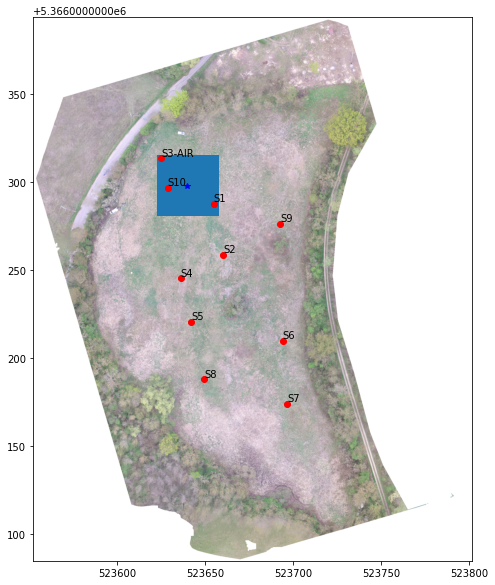

In [91]:
fig1,axrgb = plt.subplots(1,figsize=(30,10))
mid_point = [Target_x[1]-15,Target_y[1]+10]
width = 35
height = 35


axrgb.imshow(RGB.astype(rio.uint8),extent = all_band_ext)
axrgb.plot(Target_x,Target_y,"ro")
for k in range(len(Target_x)) :
    plt.text(Target_x[k],Target_y[k]+1.5,Sensor_Name[k])


axrgb.plot(mid_point[0],mid_point[1],"b*")

axrgb.add_patch(
    patches.Rectangle((mid_point[0]-(width//2),mid_point[1]-(height//2)), width, height,fill = 'False'))
plt.show()

In [40]:
ls_path_tif

['./traitement_PIREN/001_6H55_ortho_UTM31N_IR.tif',
 './traitement_PIREN/002_7H29_ortho_UTM31N_IR.tif',
 './traitement_PIREN/003_8H22_ortho_UTM31N_IR.tif',
 './traitement_PIREN/004_9H28_ortho_UTM31N_IR.tif',
 './traitement_PIREN/005_10H22_ortho_UTM31N_IR.tif',
 './traitement_PIREN/006_11H27_ortho_UTM31N_IR.tif',
 './traitement_PIREN/007_12H31_ortho_UTM31N_IR.tif',
 './traitement_PIREN/008_13H26_ortho_UTM31N_IR.tif',
 './traitement_PIREN/009_15H59_ortho_UTM31N_IR.tif',
 './traitement_PIREN/010_17H27_ortho_UTM31N_IR.tif']

In [73]:
def reading_cropped_IR(LONGUEUR,LARGEUR,x = 523658.704,y = 5366295.165,filename = './traitement_PIREN/001_6H55_ortho_UTM31N_IR.tif') :
    """ Lit un fichier .tif à 1 bands et retourne un patch carré de coté LONGUEUR au format csv pour l'execution d'un variogram
    """
    #filename = './traitement_PIREN/vis_piren_phase_HSV.tif'
    #LONGUEUR = 10
    filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
    sensor_coord = reading_gps_file(filename_Sensor_txt)
    with rio.open(filename) as dataset :
        #Value par défaut
        #win_height = 6303
        #win_width = 3421

        ls_index_target = [] # liste des valeurs indexées dans l'image
        win_height = round(LONGUEUR / dataset.res[0])
        win_width  = round(LARGEUR / dataset.res[1])
        print("Taille de la fenetre :",win_height,"x",win_width)

        # Loop pour recuperer les coordonnées UTM et convertir en indice 
        
        
        target = dataset.index(float(x),float(y))
        ls_index_target.append(target)

        dict_windows = {} # liste des paramètres dans la création d'une window
        dict_windows_param = {} # dict des targets : améliore la lisibilité

        for i,index_target in enumerate(ls_index_target) :
            print((index_target[0]-(win_height//2),(index_target[0]+(win_height//2))))
            print((index_target[1]-(win_width//2),(index_target[1]+(win_width//2))))
            win = Window.from_slices((index_target[0]-(win_height//2),
                                      (index_target[0]+(win_height//2))),
                                     (index_target[1]-(win_width//2),
                                      (index_target[1]+(win_width//2)))
                                     )
            win_transform = dataset.window_transform(win)
            all_band = dataset.read(1,window = win) # en cas de visualisation

            dict_param = {"win" : win,
                            "win_transform" : win_transform,
                           "all_band" : all_band,
                           "SensorName" : sensor_coord["SensorName"][i]}

            dict_windows_param = dict_param

            # Vecteurs linéaires avec valeurs uniforméments crées
            x_start = win_transform[2]
            x_res   = win_transform[0]
            x_end   = x_start+(float(x_res)*win.width)

            y_end   = win_transform[5]
            y_res   = win_transform[4]
            y_start = y_end + (float(y_res)*win.height)

            #print("x_end =",x_end)
            #print("y_start =",y_start)

            x = np.linspace(x_start,x_end,num = win.width)
            y = np.linspace(y_start,y_end,num = win.height)

            band_1 = []
            x_matrix = []
            y_matrix = []
            # Loop pour obtenir la valeur de chaque pt pour chaque band
            for j in range(len(x)) :
                for l in range(len(y)) :
                    for val in dataset.sample([(x[j],y[l])]): 
                        label = val[0]
                        band_1.append(label)
                        x_matrix.append(x[j]) # permet de répeter le terme 
                        y_matrix.append(y[l])
                        mapping = ['x','y','primary']
            DATA_WINDOW = pd.DataFrame(np.array([x_matrix,
                                                 y_matrix,
                                                 band_1],dtype = object).T,
                                       columns=mapping)
            
            dict_windows = DATA_WINDOW
         
            
    return dict_windows, dict_windows_param

In [ ]:
mid_point = [Target_x[1]-15,Target_y[1]+10]

In [74]:
LONGUEUR = 35
LARGEUR  = 35
dict_windows_cropped_s, dict_windows_param_cropped = reading_cropped_IR(LONGUEUR,LARGEUR,
                                                                      mid_point[0],
                                                                     mid_point[1])

Taille de la fenetre : 661 x 661
(703, 1363)
(742, 1402)


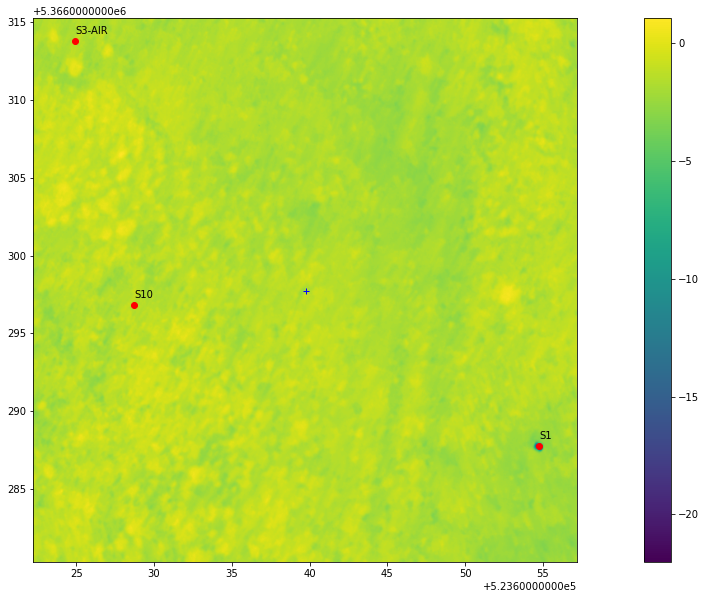

In [149]:
fig1,axrgb = plt.subplots(1,figsize=(30,10))
mid_point = [Target_x[1]-15,Target_y[1]+10]
width = 35
height = 35

IR_wind = dict_windows_param_cropped["all_band"]
win_transform = dict_windows_param_cropped["win_transform"]
all_band_ext = plotting_extent(IR_wind,win_transform)
sub_fig = axrgb.imshow(IR_wind,extent = all_band_ext)
fig1.colorbar(sub_fig,ax=axrgb,fraction=0.046, pad=0.04)

for k in [9,0,1] :
    axrgb.plot(Target_x[k],Target_y[k],"ro")
    plt.text(Target_x[k],Target_y[k]+0.5,Sensor_Name[k])


axrgb.plot(mid_point[0],mid_point[1],"b+")
plt.show()


In [105]:
dict_windows_cropped_s

,x,y,label,SensorName
0,523622.248113,5366280.327536,-1.174336,S10
1,523622.248113,5366280.380542,-1.244044,S10
2,523622.248113,5366280.433548,-1.257542,S10
3,523622.248113,5366280.486555,-1.256949,S10
4,523622.248113,5366280.539561,-1.147495,S10
...,...,...,...,...
435595,523657.179273,5366315.046671,-1.810598,S10
435596,523657.179273,5366315.099677,-1.766046,S10
435597,523657.179273,5366315.152683,-1.686758,S10
435598,523657.179273,5366315.20569,-1.581618,S10


In [169]:
x,y,SensorName,Primary, Secondary = [] ,[] , [], [] , []
filename = './traitement_PIREN/001_6H55_ortho_UTM31N_IR.tif'
for k in [9,0,1] :
    x.append(float(Sensor_coord['x'][k]))
    y.append(float(Sensor_coord['y'][k]))
    SensorName.append(Sensor_coord["SensorName"][k])
    sensor = Sensor_coord["SensorName"][k]
    Primary.append(float(dict_rms[sensor]["pseudo_temp"][0]))

for i in range(len(x)) :
    with rio.open(filename) as dataset :
        for val in dataset.sample([(x[i]-0.5,y[i]-0.5)]): 
            Secondary.append(float(val[0]))
dict_windows_cropped_p = pd.DataFrame(np.array([x,y,Primary,Secondary]).T,
                              columns = ["x","y","Primary","Secondary"])
    


In [145]:
dict_windows_cropped_s

,x,y,label,SensorName
0,523622.248113,5366280.327536,-1.174336,S10
1,523622.248113,5366280.380542,-1.244044,S10
2,523622.248113,5366280.433548,-1.257542,S10
3,523622.248113,5366280.486555,-1.256949,S10
4,523622.248113,5366280.539561,-1.147495,S10
...,...,...,...,...
435595,523657.179273,5366315.046671,-1.810598,S10
435596,523657.179273,5366315.099677,-1.766046,S10
435597,523657.179273,5366315.152683,-1.686758,S10
435598,523657.179273,5366315.20569,-1.581618,S10


# Using CollocatedCokriging workflow 

In [147]:
import os
import  matplotlib.pyplot as plt
from matplotlib import cm
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import show_hist # Useful if you wish to plot all hist and GPS target image
from rasterio.mask import mask
from shapely.geometry.point import Point
import shapely
import numpy as np
import csv
import fiona
from tools_AA_IR import reading_gps_file, circle_sensor, plottingtemp_single_label_IR
from tools_AA_IR import path_IR, get_tif,get_value_IR
from tools_AA_IR import circle_to_shape, readingIR , IR_mask, readingIR_all,alternative_readingIR_all
from tools_AA import readingtemp_AA, slice_raw, path_sonde, name_sonde, plottingtemp_single_label
from tools_EL import readingtemp, plottingtemp
from tools_AA_variograms import reading_3band, reading_cluster,get_3band
from tools_AA_variograms import reshape_3band_to_dataframe, set_bound_to_NAN
from matplotlib.gridspec import GridSpec
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import sklearn as sklearn
import seaborn as sns
from scipy.interpolate import interp1d

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys; print("  python:", sys.version_info)
import os
import scipy; print("  scipy:", scipy.__version__)
from scipy import stats
from tqdm import tqdm
from scipy.spatial import distance_matrix
from sklearn.metrics import mean_squared_error
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB                       # GSLIB utilies, visualization and wrapper


  python: sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)
  sklearn: 0.24.1
  scipy: 1.6.2


(10, 10)


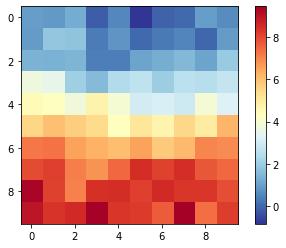

In [534]:
# Primary Data
xx_im,yy_im = np.mgrid[0:0.5 * np.pi:10j,0:0.8 * np.pi:10j]

# Add Noise

np.random.seed(21)
mu, sigma = 0, 0.5
_field_p    = np.sin(xx_im)**2 * 8 + np.cos(yy_im)**2 + np.random.normal(mu, sigma, (10,  10))  # Fonction 2D test 
_field_ps   = np.sin(xx_im)**2 + np.cos(yy_im)**2 + np.random.normal(mu, sigma, (10,  10))       # Fonction 2D secondary 

xx_p, yy_p = np.mgrid[0:500:50, 0:500:50]
figg = plt.imshow(_field_p, cmap='RdYlBu_r')
plt.colorbar(figg)

# DataFrame
datafl = pd.DataFrame()
datafl["X"] = xx_p.reshape(-1)
datafl["Y"] = yy_p.reshape(-1)
datafl["Primary_original"] = _field_p.reshape(-1)
datafl["Secondary_original"] = _field_ps.reshape(-1)
datafl["Primary"] = geostats.nscore(datafl,"Primary_original")[0]
datafl["Secondary"] = geostats.nscore(datafl,"Secondary_original")[0]
print(xx_p.shape)

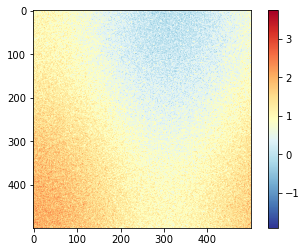

In [492]:
#Secondary Data
x, y = np.mgrid[0:0.5 * np.pi:500j, 0:0.8 * np.pi:500j]

# Add some noise

np.random.seed(42)
mu, sigma = 0, 0.5
_field = np.sin(x)**2 + np.cos(y)**2 + np.random.normal(mu, sigma, (500,  500)) 



xx, yy = np.mgrid[0:500, 0:500]
figg = plt.imshow(_field, cmap='RdYlBu_r')
plt.colorbar(figg)

datafl_sec = pd.DataFrame()
datafl_sec["X"] = xx.reshape(-1)
datafl_sec["Y"] = yy.reshape(-1)
datafl_sec["Secondary_original"] = _field.reshape(-1)
datafl_sec["Secondary"] = geostats.nscore(datafl_sec,"Secondary_original")[0]

In [5]:
datafl # Dataframe Primary

,X,Y,Primary_original,Secondary_original,Primary,Secondary
0,0,0,46.000000,11.000000,0.113039,0.113039
1,0,50,46.030154,10.969846,0.163658,-0.138304
2,0,100,46.116978,10.883022,0.266311,-0.240426
3,0,150,46.250000,10.750000,0.510073,-0.481727
4,0,200,46.413176,10.586824,0.755415,-0.722479
...,...,...,...,...,...,...
95,450,250,45.586824,11.413176,-0.722479,0.755415
96,450,300,45.750000,11.250000,-0.481727,0.510073
97,450,350,45.883022,11.116978,-0.240426,0.266311
98,450,400,45.969846,11.030154,-0.138304,0.163658


In [148]:
datafl_sec # Dataframe Secondary

,X,Y,Secondary_original,Secondary
0,0,0,11.000000,0.187327
1,0,1,10.999975,0.186256
2,0,2,10.999899,0.186042
3,0,3,10.999772,0.185583
4,0,4,10.999594,0.184859
...,...,...,...,...
249995,499,495,11.635228,1.396261
249996,499,496,11.640070,1.405327
249997,499,497,11.644898,1.414265
249998,499,498,11.649711,1.423208


In [535]:
datafl.to_csv("dataf1_noise_2.csv")
datafl_sec.to_csv("dataf1_sec_noise_2.csv")

In [446]:
datafl = pd.read_csv("dataf1.csv")
datafl_sec =  pd.read_csv("dataf1_sec.csv")

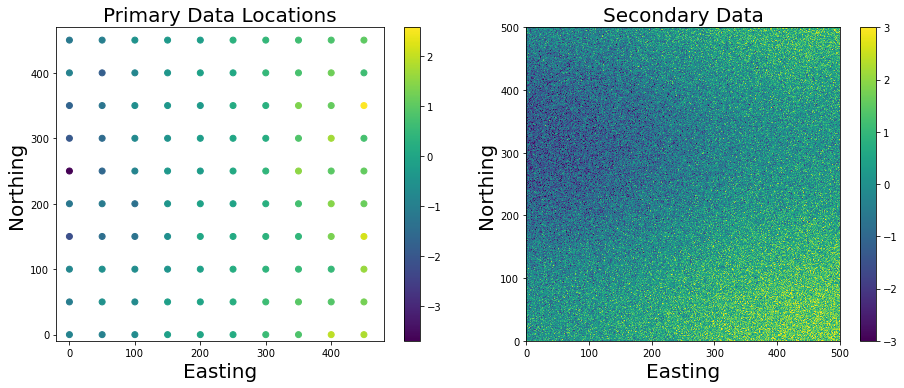

In [536]:
vlim = (-3, 3)
f, ax = plt.subplots(1, 2, figsize=(13, 5.5))
XMIN, XMAX = 0, 500
YMIN, YMAX = 0, 500
SMIN, SMAX = -3, 3

gridd = pd.DataFrame()
gridd["Y"] = yy.reshape(-1)
gridd["X"] = xx.reshape(-1)
gridd["Estimate"] = datafl_sec["Secondary"]
gridded = np.reshape(
    gridd.sort_values(by=["Y", "X"], axis=0, ascending=True)[
        "Estimate"
    ].values,
    [500, 500],
    order="C",
)

img0 = ax[0].scatter(datafl["X"], datafl["Y"], c=datafl["Primary"].values)
ax[0].set_title("Primary Data Locations", size=20)
ax[0].set_xlabel("Easting", size=20)
ax[0].set_ylabel("Northing", size=20)
ax[0].axis("equal")
ax[0].set(xlim=(XMIN-20, XMAX-20), ylim=(YMIN-20, YMAX-20))
img1 = ax[1].imshow(
    gridded,
    origin="lower",
    extent=[XMIN, XMAX, YMIN, YMAX],
    aspect="equal",
    interpolation="none",
    vmin=SMIN,
    vmax=SMAX,
    cmap="viridis",
)
    
ax[1].set_xlabel("Easting", size=20)
ax[1].set_ylabel("Northing", size=20)
ax[1].set_title("Secondary Data", size=20)
f.colorbar(img0, ax=ax[0])
f.colorbar(img1, ax=ax[1])
plt.tight_layout()
#plt.savefig("truth.png", bbox_inches="tight", dpi=300)

Text(6.5, -2.75, 'Var = 1.00')

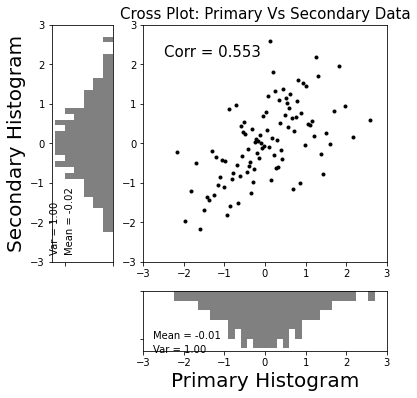

In [537]:
# Set up the axes with gridspec
corr = np.corrcoef(datafl["Primary"], datafl["Secondary"])[0, 1]
vlim = (-3, 3)
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.5)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(datafl["Primary"], datafl["Secondary"], "ok", markersize=3)
main_ax.set_xlim(vlim)
main_ax.set_ylim(vlim)
main_ax.set_title("Cross Plot: Primary Vs Secondary Data", size=15)
main_ax.text(-2.5, 2.2,
    "Corr = {0:.3f}".format(
        np.corrcoef(datafl["Primary"], datafl["Secondary"])[0, 1]
    ),
    size=15
)

# histogram on the attached axes
x_hist.hist(
    datafl["Primary"],
    40,
    histtype="stepfilled",
    label="Primary",
    orientation="vertical",
    color="gray",
    range=vlim,
)
x_hist.set_xlabel("Primary Histogram", size=20)
x_hist.invert_yaxis()
x_hist.text(-2.75, 5, "Mean = {0:.2f}".format(np.average(datafl["Primary"])),
            size=10)
x_hist.text(-2.75, 6.5, "Var = {0:.2f}".format(1.00), size=10)


y_hist.hist(
    datafl["Secondary"],
    40,
    histtype="stepfilled",
    orientation="horizontal",
    color="gray",
    range=vlim,
)
y_hist.set_ylabel("Secondary Histogram", size=20)
y_hist.invert_xaxis()
y_hist.text(5, -2.75, "Mean = {0:.2f}".format(np.average(datafl["Secondary"])),
            rotation=90, size=10)
y_hist.text(6.5, -2.75, "Var = {0:.2f}".format(1.00), rotation=90, size=10)

# Correlograms

## Initialize Correlogram Types

In [444]:
def covar(t, d, r):
    h = d / r
    if t == 1:  # Spherical
        c = 1 - h * (1.5 - 0.5 * np.square(h))
        c[h > 1] = 0
    elif t == 2:  # Exponential
        c = np.exp(-3 * h)
    elif t == 3:  # Gaussian
        c = np.exp(-3 * np.square(h))
    return c

#### Method \#3: Experimental Variograms

Another method for exploring spatial data directionality is the calculation of multiple experimental variograms for a variety of directions.

We can use the location maps to help determine good variogram calculation parameters.

```p
tmin = -9999.; tmax = 9999.; 
lag_dist = 100.0; lag_tol = 50.0; nlag = 7; bandh = 9999.9; azi = azi; atol = 22.5; isill = 1
```
* **tmin**, **tmax** are trimming limits - set to have no impact, no need to filter the data
* **lag_dist**, **lag_tol** are the lag distance, lag tolerance - set based on the common data spacing (100m) and tolerance as 100% of lag distance for additonal smoothing
* **nlag** is number of lags - set to extend just past 50 of the data extent
* **bandh** is the horizontal band width - set to have no effect
* **azi** is the azimuth -  it has not effect since we set atol, the azimuth tolerance, to 90.0
* **isill** is a boolean to standardize the distribution to a variance of 1 - it has no effect since the nscore transform sets the variance to 1.0

In [21]:
lag_size = 50 #en mètre
patch_size = 500 # en mètre
int(1/lag_size * (patch_size/2))

5

In [269]:
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = 5; lag_tol = 5; nlag = 100;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 22.5                            # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [0,22.5,45,67.5,90,112.5,135,157.5]           # directions in azimuth to consider

#### Primary

In [270]:
# Arrays to store the results
#lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));

#for iazi in range(0,len(azi_mat)):                      # Loop over all directions
 #   lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(datafl,"X","Y","Primary",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
 #   print("completed azimuth :",iazi)


completed azimuth : 0
completed azimuth : 1
completed azimuth : 2
completed azimuth : 3
completed azimuth : 4
completed azimuth : 5
completed azimuth : 6
completed azimuth : 7


In [546]:
dict_vario = {}
for i in range(2) :
    var = "vario_noise_prim_{}.dat".format(i)
    df_vario = pd.read_csv(str(var),sep = ' ',names = ["Lag Distance","Variogram Value","Number of Pairs"])
    df_vario["Calculation Azimuth"] = azi_mat[i]
    dict_vario[i] = df_vario

In [550]:
dict_vario

{0:      Lag Distance  Variogram Value  Number of Pairs  Calculation Azimuth
 NaN     50.000000         0.152969               90                    0
 NaN    100.000000         0.334586               80                    0
 NaN    111.803399         0.356686               72                    0
 NaN    150.000000         0.626134               70                    0
 NaN    158.113883         0.661126               63                    0
 NaN    180.277564         0.723606               56                    0
 NaN    200.000000         0.963646               60                    0
 NaN    206.155281         1.044687               54                    0,
 1:      Lag Distance  Variogram Value  Number of Pairs  Calculation Azimuth
 NaN     50.000000         0.173457               90                 22.5
 NaN     70.710678         0.171007               81                 22.5
 NaN    100.000000         0.167585               80                 22.5
 NaN    111.803399         0.21

In [551]:
# Primary
data = []
mapping = ["Variogram Index","Lag Distance",
           "Variogram Value","Number of Pairs",
           "Calculation Azimuth"]
azii = [112.5,45]
for n,i in enumerate([0,1]) :
    print(i)
    LAG = dict_vario[i]["Lag Distance"]
    GAMMA = dict_vario[i]["Variogram Value"]
    AZIMUTH = np.ones(len(LAG)) * azii[i]
    NPP = dict_vario[i]["Number of Pairs"] # Number of Pairs
    
    if n == 0 :
        index = np.ones(len(LAG))
        
    else :
        index = np.ones(len(LAG)) * 2
        
    for a,b,c,d,e in zip(index,LAG,GAMMA,NPP,AZIMUTH) : 
        data.append([a,b,c,d,e])
        
varcalcfl_1 = pd.DataFrame(data,columns= mapping )
varcalcfl_1.to_csv("varcalcfl_1.csv") # Sauvegarde du csv 


0
1


In [552]:
varcalcfl_1

,Variogram Index,Lag Distance,Variogram Value,Number of Pairs,Calculation Azimuth
0,1.0,50.000000,0.152969,90,112.5
1,1.0,100.000000,0.334586,80,112.5
2,1.0,111.803399,0.356686,72,112.5
3,1.0,150.000000,0.626134,70,112.5
4,1.0,158.113883,0.661126,63,112.5
5,1.0,180.277564,0.723606,56,112.5
6,1.0,200.000000,0.963646,60,112.5
7,1.0,206.155281,1.044687,54,112.5
8,2.0,50.000000,0.173457,90,45.0
9,2.0,70.710678,0.171007,81,45.0


In [553]:
varcalcfl_1[varcalcfl_1["Variogram Index"] == 2] # 1 -> Major or 2 -> Minor

,Variogram Index,Lag Distance,Variogram Value,Number of Pairs,Calculation Azimuth
8,2.0,50.000000,0.173457,90,45.0
9,2.0,70.710678,0.171007,81,45.0
10,2.0,100.000000,0.167585,80,45.0
11,2.0,111.803399,0.213637,72,45.0
12,2.0,141.421356,0.372682,64,45.0
13,2.0,150.000000,0.233379,70,45.0
14,2.0,158.113883,0.229626,63,45.0
15,2.0,180.277564,0.408387,56,45.0
16,2.0,200.000000,0.215116,60,45.0
17,2.0,206.155281,0.228252,54,45.0


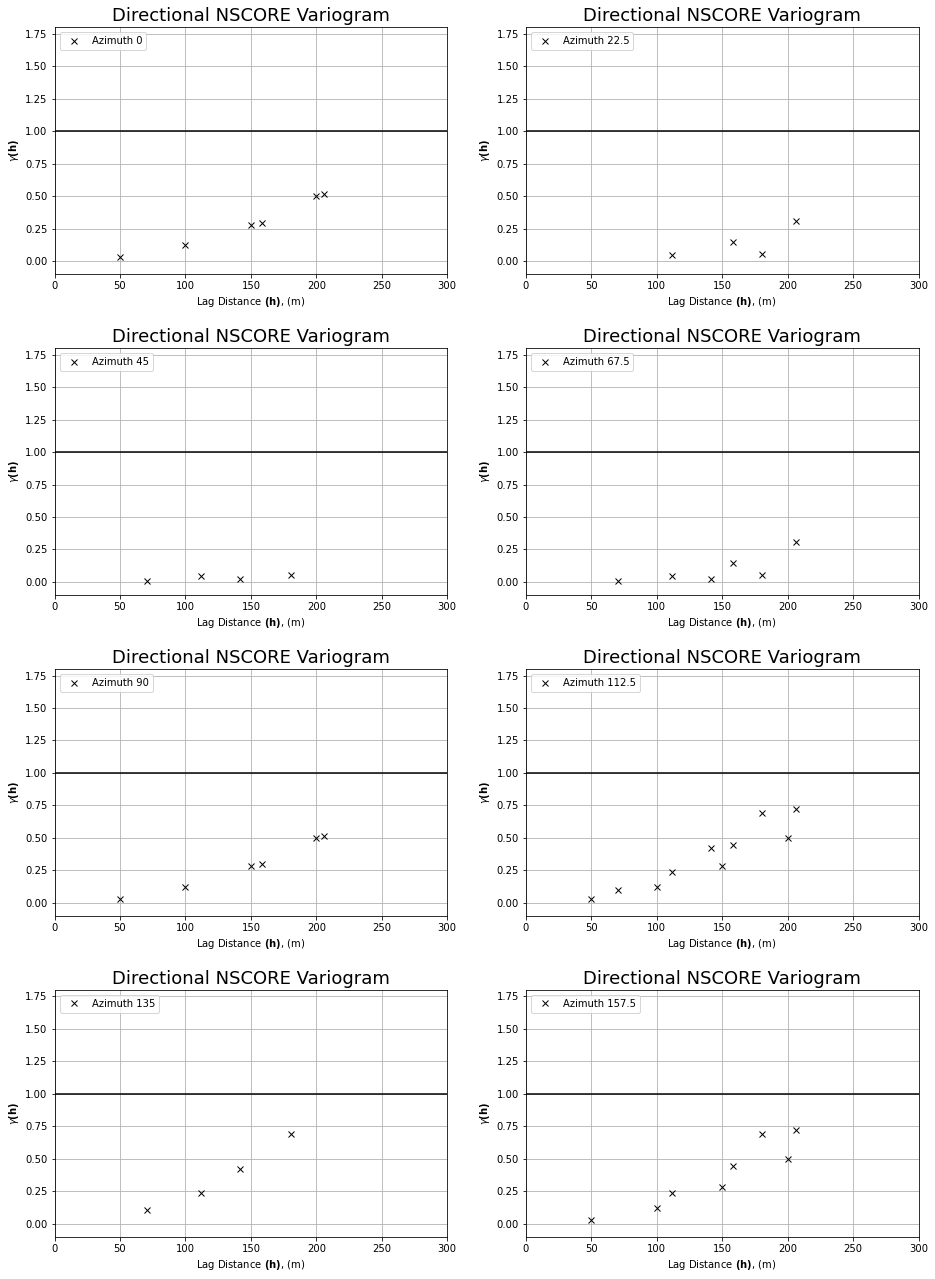

In [374]:
#for primary
for iazi,n in enumerate(range(0,len(azi_mat))):                     # Loop over all directions
    lag = dict_vario[n]["Lag Distance"]
    gamma = dict_vario[n]["Variogram Value"]
    plt.subplot(4,2,iazi+1)
    plt.plot(lag,gamma,'x',color = 'black',label = 'Azimuth ' +str(azi_mat[iazi]))
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional NSCORE Variogram')
    plt.xlim([0,300])
    plt.ylim([-0.1,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

# _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____       

#### Secondary

In [555]:
# Secondary

dict_vario = {}
for i in range(2) :
    var = "vario_noise_{}.dat".format(i)
    df_vario = pd.read_csv(str(var),sep = ' ',names = ["Lag Distance","Variogram Value","Number of Pairs"])
    df_vario["Calculation Azimuth"] = azi_mat[i]
    dict_vario[i] = df_vario
    

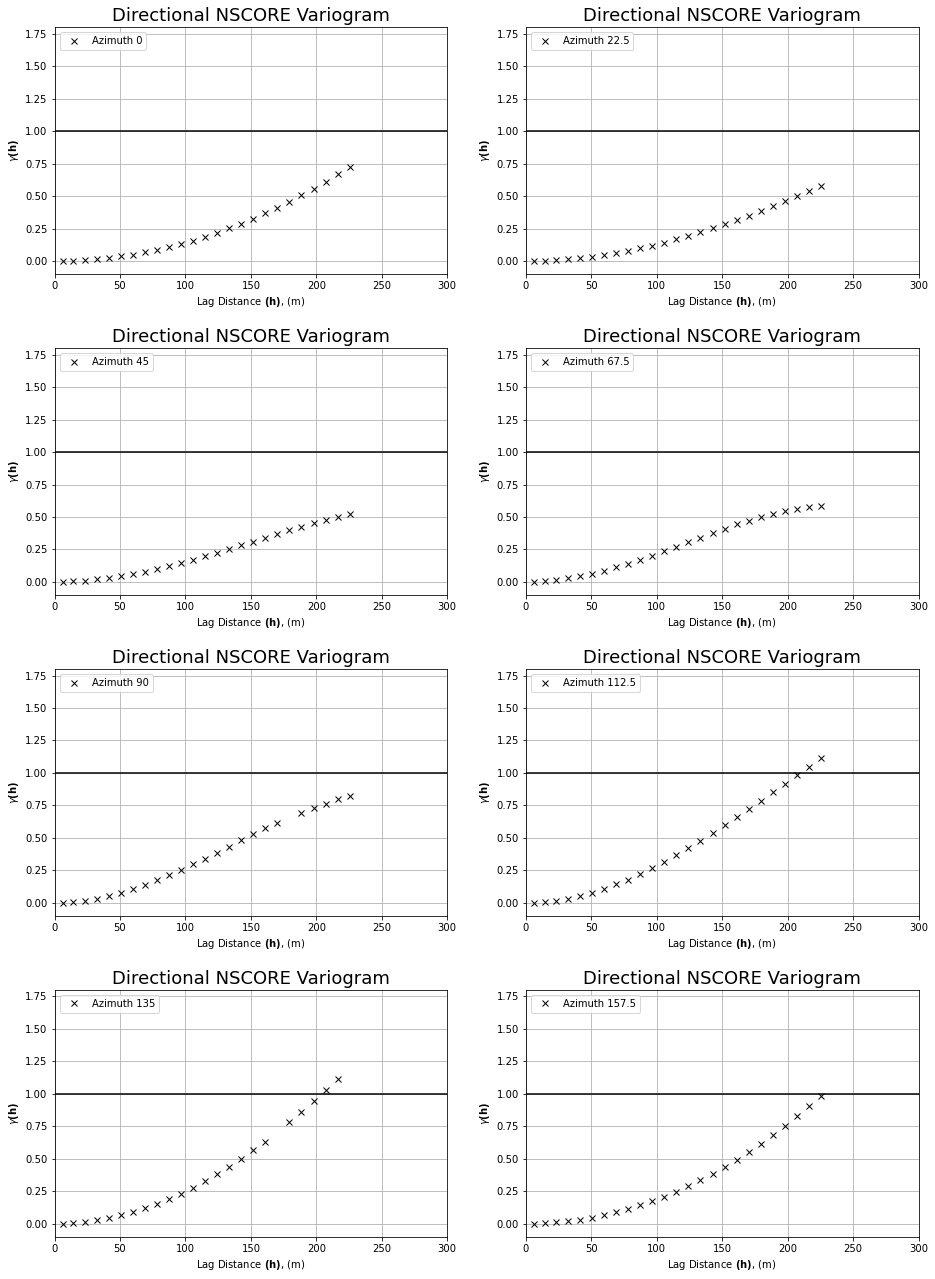

In [460]:
# for secondary
for iazi,n in enumerate(range(0,len(azi_mat))):                     # Loop over all directions
    lag = dict_vario[n]["Lag Distance"]
    gamma = dict_vario[n]["Variogram Value"]
    plt.subplot(4,2,iazi+1)
    plt.plot(lag,gamma,'x',color = 'black',label = 'Azimuth ' +str(azi_mat[iazi]))
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional NSCORE Variogram')
    plt.xlim([0,300])
    plt.ylim([-0.1,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

In [556]:
dict_vario

{0:      Lag Distance  Variogram Value  Number of Pairs  Calculation Azimuth
 NaN      6.072081         0.519003          7866593                    0
 NaN     15.664545         0.520503         32783871                    0
 NaN     25.596276         0.523397         42108111                    0
 NaN     34.695377         0.527710         56656406                    0
 NaN     45.071470         0.534021         89038475                    0
 NaN     55.284471         0.541380         84880920                    0
 NaN     64.491478         0.549493         96868445                    0
 NaN     74.867709         0.559829        135014863                    0
 NaN     85.157237         0.571201        120253071                    0
 NaN     94.369128         0.582279        128882843                    0
 NaN    104.719828         0.595460        172337783                    0
 NaN    115.036499         0.609685        147177401                    0
 NaN    125.424489         0.624494

In [557]:
# Secondary
data = []
mapping = ["Variogram Index","Lag Distance",
           "Variogram Value","Number of Pairs",
           "Calculation Azimuth"]

azii = [112.5,45]
for n,i in enumerate([0,1]) :
    print(i)
    LAG = dict_vario[i]["Lag Distance"]
    GAMMA = dict_vario[i]["Variogram Value"]
    AZIMUTH = np.ones(len(LAG)) * azii[i]
    print(AZIMUTH)
    NPP = dict_vario[i]["Number of Pairs"] # Number of Pairs
    if n == 0 :
        index = np.ones(len(LAG))
        
    else :
        index = np.ones(len(LAG)) * 2
    print(index)
    for a,b,c,d,e in zip(index,LAG,GAMMA,NPP,AZIMUTH) : 
        data.append([a,b,c,d,e])
        
varcalcfl_2 = pd.DataFrame(data,columns= mapping )
varcalcfl_2.to_csv("varcalcfl_2.csv") # Sauvegarde du csv 


0
[112.5 112.5 112.5 112.5 112.5 112.5 112.5 112.5 112.5 112.5 112.5 112.5
 112.5 112.5 112.5 112.5 112.5 112.5 112.5 112.5 112.5 112.5 112.5]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1
[45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45. 45.
 45. 45. 45. 45. 45.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [558]:
varcalcfl_2[varcalcfl_2["Variogram Index"] == 2] # 1 or 2

,Variogram Index,Lag Distance,Variogram Value,Number of Pairs,Calculation Azimuth
23,2.0,5.853407,0.519065,9362415,45.0
24,2.0,15.614929,0.522068,33628927,45.0
25,2.0,25.531368,0.527258,43525385,45.0
26,2.0,34.693585,0.534799,58240999,45.0
27,2.0,45.087256,0.545940,90802442,45.0
28,2.0,55.280838,0.559565,86549930,45.0
29,2.0,64.444288,0.574454,98648799,45.0
30,2.0,74.838343,0.593978,139285951,45.0
31,2.0,85.157324,0.615637,122657160,45.0
32,2.0,94.341345,0.636851,131880548,45.0


# _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____ _____       

#### Cross - Correlation

In [462]:
# Arrays to store the results
lag_cc = np.zeros((len(azi_mat),nlag+2)); gamma_cc = np.zeros((len(azi_mat),nlag+2)); npp_cc = np.zeros((len(azi_mat),nlag+2));

for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag_cc[iazi,:], gamma_cc[iazi,:], npp_cc[iazi,:] = geostats.gamv(datafl,"X","Y","Secondary",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    print("completed azimuth :",iazi)


completed azimuth : 0
completed azimuth : 1
completed azimuth : 2
completed azimuth : 3
completed azimuth : 4
completed azimuth : 5
completed azimuth : 6
completed azimuth : 7


In [463]:
# Cross
data = []
mapping = ["Variogram Index","Lag Distance",
           "Variogram Value","Number of Pairs",
           "Calculation Azimuth"]

for n,i in enumerate([6,5]) :
    print(i)
    LAG = lag_cc[i]
    GAMMA = gamma_cc[i] # Variogram Value
    AZIMUTH = np.ones(len(LAG)) * azi_mat[i]
    NPP = npp_cc[i] # Number of Pairs
    if n == 1 :
        index = np.ones(len(LAG))
        
    else :
        index = np.ones(len(LAG)) * 2
        
    for a,b,c,d,e in zip(index,LAG,GAMMA,NPP,AZIMUTH) : 
        data.append([a,b,c,d,e])
        
varcalcfl_3 = pd.DataFrame(data,columns= mapping )
Mask_1 = varcalcfl_3["Lag Distance"] != 0 # Mask sur les valeurs différentes de 0 
varcalcfl_3.loc[Mask_1]
varcalcfl_3 = varcalcfl_3.loc[Mask_1]
varcalcfl_3 = varcalcfl_3.drop_duplicates(subset = ["Lag Distance"]) # Supprime les doublons !! 
varcalcfl_3.to_csv("varcalcfl_3.csv") # Sauvegarde du csv 


6
5


In [389]:
varcalcfl_3[varcalcfl_3["Variogram Index"] == 1] # 1 or 2

,Variogram Index,Lag Distance,Variogram Value,Number of Pairs,Calculation Azimuth
112,1.0,50.000000,0.033154,180.0,112.5
122,1.0,100.000000,0.133044,160.0,112.5
125,1.0,111.803399,0.245101,144.0,112.5
132,1.0,145.902737,0.408599,268.0,112.5
133,1.0,150.000000,0.308540,140.0,112.5
134,1.0,153.843418,0.370601,266.0,112.5
135,1.0,158.113883,0.439558,126.0,112.5
139,1.0,180.277564,0.747143,112.0,112.5
142,1.0,200.000000,0.558686,120.0,112.5
144,1.0,202.915660,0.631708,228.0,112.5


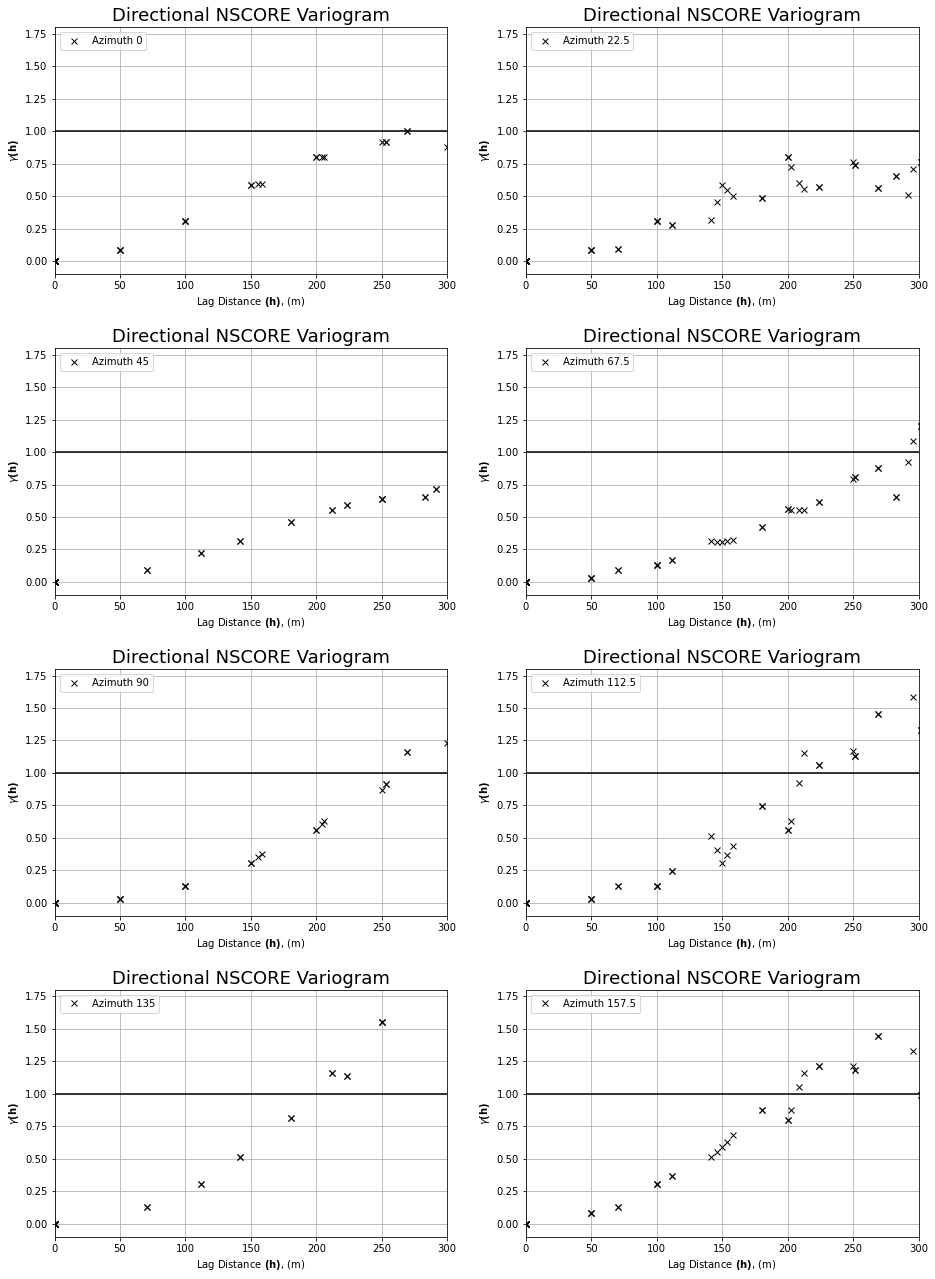

In [276]:
#for primary
for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    plt.subplot(4,2,iazi+1)
    plt.plot(lag_cc[iazi,:],gamma_cc[iazi,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[iazi]))
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional NSCORE Variogram')
    plt.xlim([0,300])
    plt.ylim([-0.1,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

In [224]:
# varcalcfl_1 : Primary Variogram
# varcalcfl_2 : Secondary Variogram (Surfer)
# varcalcfl_3 : Cross Variogram

-0.9955705711722941

<ipython-input-579-2accab576973>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[j, i].plot(
<ipython-input-579-2accab576973>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[j, i].plot(
<ipython-input-579-2accab576973>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[j, i].plot(
<ipython-input-579-2accab576973>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[j, i].plot(
<ipython-input-579-2accab576973>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'

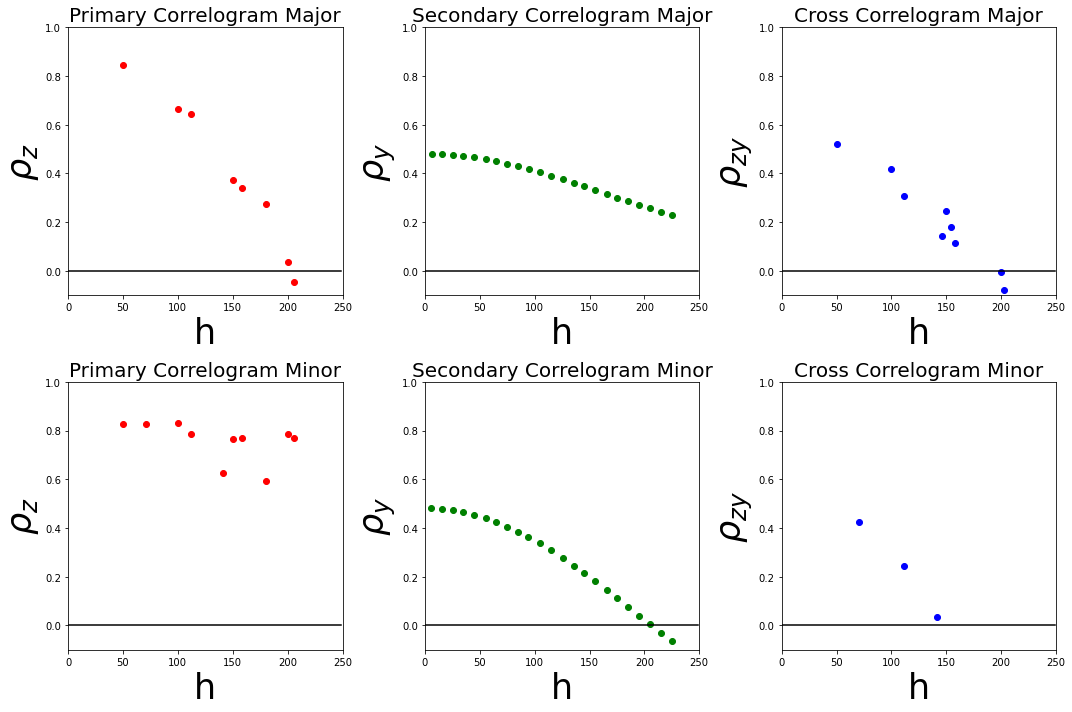

In [579]:
LENGTH = 250 # 1/2 dist en m
ones = np.zeros(shape=(LENGTH))
Cross_ones = np.zeros(shape=(LENGTH))
H = np.zeros(shape=(LENGTH))
Corr_labels = [
    "Primary Correlogram",
    "Secondary Correlogram",
    "Cross Correlogram",
]
Directions = ["Major", "Minor"]
colors = ["Red", "Green", "Blue"]
labels_2 = ["$\u03C1_{z}$", "$\u03C1_{y}$", "$\u03C1_{zy}$"]
Sill_vals = [1, 1, corr]
for h in range(1, LENGTH):
    H[h] = h
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(0, 3):
    var = locals()["varcalcfl_{}".format(i + 1)]
    for j in range(0, 2):
        axes[j, i].plot(
            var["Lag Distance"][var["Variogram Index"] == (j + 1)],
            Sill_vals[i]
            - var["Variogram Value"][var["Variogram Index"] == (j + 1)],
            "ro",
            color=colors[i],
        )
        axes[j, i].set_ylabel(labels_2[i], size=35)
        axes[j, i].plot(H, ones, color="Black")
        axes[j, i].set_xlabel("h", size=35)
        axes[j, i].set_title(Corr_labels[i] + " " + Directions[j], size=20)
plt.setp(axes, xlim=(0, LENGTH), ylim=(-0.1, 1))
plt.tight_layout()
#plt.savefig('true_variograms.png', bbox_inches="tight", dpi=300)

## Calculate Rotation Matrix

Using a major direction of 90 degrees east of north, this is farily obvious from the primary and secondary data. See http://www.geostatisticslessons.com/lessons/anglespecification

In [281]:
def Rot_Mat(Azimuth, a_max, a_min):
    theta = (Azimuth / 180.0) * np.pi
    Rot_Mat = np.dot(
        np.array([[1 / a_max, 0], [0, 1 / a_min]]),
        np.array(
            [
                [np.cos(theta), np.sin(theta)],
                [-np.sin(theta), np.cos(theta)],
            ]
        ),
    )
    return Rot_Mat

## Primary Correlogram

In [470]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z(h1, h2, k,a_max,a_min):
    C = []
    nstruct = 1
    vtype = [3] # Gaussian
    #a_max = [24]
    #a_min = [16]
    #a_max = [80]
    #a_min = [320]
    Azimuth = 112.5
    cc = [1]
    c = 0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

## Secondary Correlogram

In [589]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Y(h1, h2, k,a_max,a_min):
    C = []
    nstruct = 2
    vtype = [1, 3]
    #a_max = [42, 43]
    #a_min = [28.5, 30]
    #a_max = [380,360]
    #a_min = [340,300]
    Azimuth = 112.5
    cc = [0.9, 0.1]
    c = 0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                )
            ).sum(axis=1)
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

## Scalling Correlogram

In [417]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_r(h1, h2, k):
    C = []
    nstruct = 1
    vtype = [3] # Gaussian
    #a_max = [18] # angle maximum de recherche
    #a_min = [13] # angle minimim de recherche
    a_max = [350]
    a_min = [300]
    Azimuth = 112.5
    cc = [1]
    c = 0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

## C_Z Correlogram MM2

In [330]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# Corr = correlation between primary and secondary data
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z_MM2(h1, h2, k, corr):
    return (C_Y(h1, h2, k) * corr ** 2) + (
        (1 - corr ** 2) * C_r(h1, h2, k)
    )

## Plots Correlogram Models

In [584]:
# Define some matrices for storing variogram values
cy = np.zeros(shape=(LENGTH + 1))
cz_True = np.zeros(shape=(LENGTH + 1))
cr = np.zeros(shape=(LENGTH + 1))
cz = np.zeros(shape=(LENGTH + 1))
czy = np.zeros(shape=(LENGTH + 1))
H = np.zeros(shape=(LENGTH + 1))
ones = np.zeros(shape=(LENGTH + 1))
cy_LMC = np.zeros(shape=(LENGTH + 1))
cz_LMC = np.zeros(shape=(LENGTH + 1))
czy_LMC = np.zeros(shape=(LENGTH + 1))
# Define some plotting labels
labels_1 = [
    "$\hat{\u03C1_{z}}$",
    "$\hat{\u03C1_{y}}$",
    "$\hat{\u03C1_{zy}}$",
]
labels_MM = [
    "$\u03C1_{z_{Model}}$",
    "$\u03C1_{y_{Model}}$",
    "$\u03C1_{z_{MMII}}$",
]
labels_lmc = [
    "$\u03C1_{z_{LMC}}$",
    "$\u03C1_{y_{LMC}}$",
    "$\u03C1_{zy_{LMC}}$",
]
colors_lmc = ["Orange", "Yellow", "Grey"]

In [509]:
np.linspace(50,150,11)[0]

50.0

In [497]:
Directions

['Major', 'Minor']

In [570]:
for s in range(1, 2) :
    print(s)

1


200.0 100.0


ValueError: x and y must have same first dimension, but have shapes (250,) and (251,)

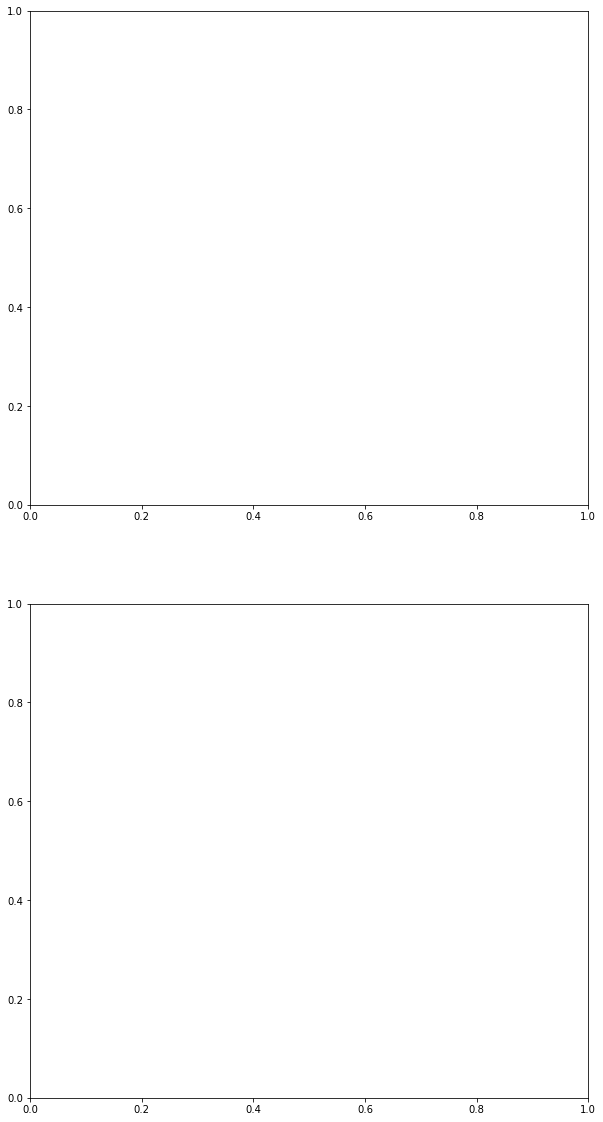

In [581]:
# MODIFIEE
varg_type = 2  # See Correlogram Functions : 2 = Major Direction

a_max_mesh = np.linspace(200,300,11)
a_min_mesh = np.linspace(100,200,11)

k = 0
fig, axes = plt.subplots(2, 1, figsize=(10, 20))
for Dir in Directions:
    
    for a_max,a_min in zip(a_max_mesh,a_min_mesh) :
        print(a_max,a_min)
        
        for h in range(0, LENGTH + 1):
            cz_True[h] = C_Z(np.matrix(h), np.matrix(h), varg_type,[a_max],[a_min])
        MM_vargs = [ cz_True,None,None ]
        
        for i in range(0, 1):
            if Dir == "Major" : 
                LABEL =  "range = {}".format(a_max)
            else :
                LABEL =  "range = {}".format(a_min)
            axes[k].plot(H, MM_vargs[i], label=LABEL)
            if (i + 1) < 3:
               
                    
                var = locals()["varcalcfl_{}".format(i + 1)]
                axes[k].plot(
                    var["Lag Distance"][
                        var["Variogram Index"] == (varg_type - 1)
                    ],
                    Sill_vals[i]
                    - var["Variogram Value"][
                        var["Variogram Index"] == (varg_type - 1)
                    ],
                    "ro",
                    color=colors[i]
                )

    axes[k].plot(H, ones, color="Black")
    axes[k].grid()
    axes[k].set_xlim(0, LENGTH + 1)
    axes[k].set_ylim(-0.1, 1)
    axes[k].set_ylabel("\u03C1(h)", size=35)
    axes[k].set_xlabel("h", size=35)
    axes[k].set_title(
        "MMI  Correlogram Comparison {} Direction".format(Dir),
        size=25,
    )
    axes[k].legend(loc="best", prop={"size": 8})
    #plt.savefig("MM1_MM2_var_{}".format(Dir), bbox_inches="tight", dpi=300)
    varg_type = varg_type + 1
    k +=1

In [592]:
cy

array([1.00000000e+00, 9.86470454e-01, 9.72883672e-01, 9.59242514e-01,
       9.45549950e-01, 9.31809055e-01, 9.18023011e-01, 9.04195102e-01,
       8.90328715e-01, 8.76427337e-01, 8.62494553e-01, 8.48534044e-01,
       8.34549583e-01, 8.20545030e-01, 8.06524333e-01, 7.92491522e-01,
       7.78450705e-01, 7.64406064e-01, 7.50361851e-01, 7.36322385e-01,
       7.22292044e-01, 7.08275263e-01, 6.94276531e-01, 6.80300380e-01,
       6.66351386e-01, 6.52434162e-01, 6.38553351e-01, 6.24713625e-01,
       6.10919675e-01, 5.97176210e-01, 5.83487949e-01, 5.69859620e-01,
       5.56295949e-01, 5.42801660e-01, 5.29381470e-01, 5.16040083e-01,
       5.02782183e-01, 4.89612436e-01, 4.76535479e-01, 4.63555922e-01,
       4.50678339e-01, 4.37907268e-01, 4.25247204e-01, 4.12702601e-01,
       4.00277863e-01, 3.87977345e-01, 3.75805349e-01, 3.63766122e-01,
       3.51863854e-01, 3.40102675e-01, 3.28486655e-01, 3.17019801e-01,
       3.05706056e-01, 2.94549298e-01, 2.83553340e-01, 2.72721929e-01,
      

300.0 100.0
310.0 110.0
320.0 120.0
330.0 130.0
340.0 140.0


<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keywo

350.0 150.0
360.0 160.0
370.0 170.0
380.0 180.0


<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keywo

390.0 190.0
400.0 200.0
300.0 100.0
310.0 110.0
320.0 120.0


<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  axes[k].plot(


330.0 130.0
340.0 140.0
350.0

<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  axes[k].plot(


 150.0
360.0 160.0


<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  axes[k].plot(
<ipython-input-593-9795c6736828>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keywo

370.0 170.0
380.0 180.0
390.0 190.0
400.0 200.0


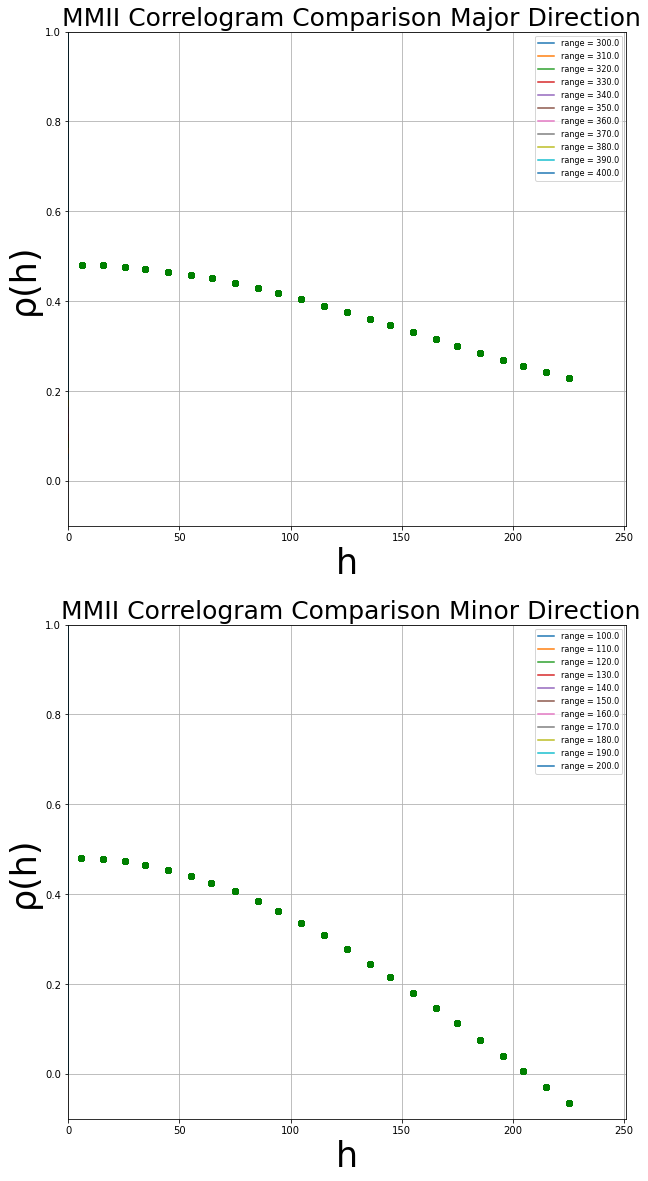

In [593]:
# MODIFIEE
varg_type = 2  # See Correlogram Functions : 2 = Major Direction

a_max_mesh = np.linspace(300,400,11)
a_min_mesh = np.linspace(100,200,11)

k = 0
fig, axes = plt.subplots(2, 1, figsize=(10, 20))
for Dir in Directions:
    
    for a_max,a_min in zip(a_max_mesh,a_min_mesh) :
        print(a_max,a_min)
        
        for h in range(0, LENGTH + 1):
            cy[h] = C_Y(np.matrix(h), np.matrix(h), varg_type,[a_max,a_max],[a_min,a_min])
        MM_vargs = [ 0,cy,None ]
        
        for i in range(1, 2):
            if Dir == "Major" :
                
                LABEL =  "range = {}".format(a_max)
            else :
                LABEL =  "range = {}".format(a_min)
                    
            axes[k].plot(H, MM_vargs[i], label=LABEL)
            if (i + 1) < 3:    
                var = locals()["varcalcfl_{}".format(i + 1)]
                axes[k].plot(
                    var["Lag Distance"][
                        var["Variogram Index"] == (varg_type - 1)
                    ],
                    Sill_vals[i]
                    - var["Variogram Value"][
                        var["Variogram Index"] == (varg_type - 1)
                    ],
                    "go",
                    color=colors[i],
                )

    axes[k].plot(H, ones, color="Black")
    axes[k].grid()
    axes[k].set_xlim(0, LENGTH + 1)
    axes[k].set_ylim(-0.1, 1)
    axes[k].set_ylabel("\u03C1(h)", size=35)
    axes[k].set_xlabel("h", size=35)
    axes[k].set_title(
        " MMII Correlogram Comparison {} Direction".format(Dir),
        size=25,
    )
    axes[k].legend(loc="best", prop={"size": 8})
    #plt.savefig("MM1_MM2_var_{}".format(Dir), bbox_inches="tight", dpi=300)
    varg_type = varg_type + 1
    k +=1

<ipython-input-427-0b73f3d08a06>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes.plot(
<ipython-input-427-0b73f3d08a06>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes.plot(
<ipython-input-427-0b73f3d08a06>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes.plot(
<ipython-input-427-0b73f3d08a06>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes.plot(


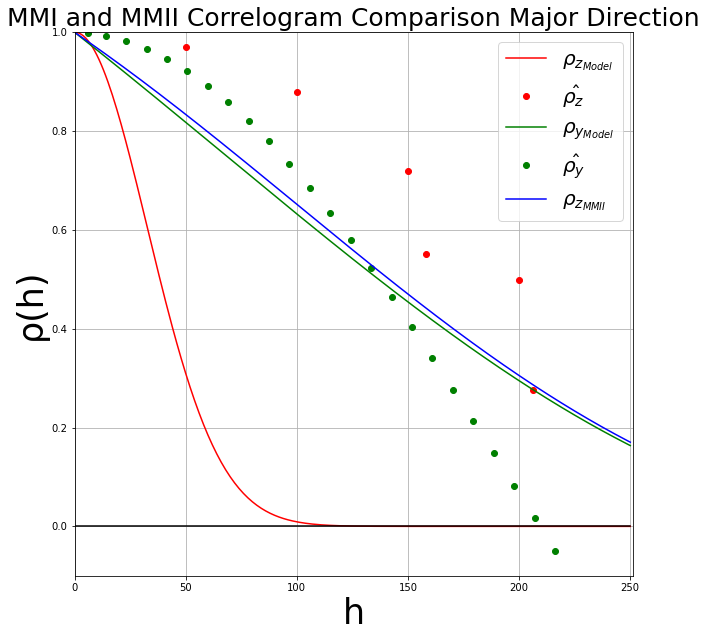

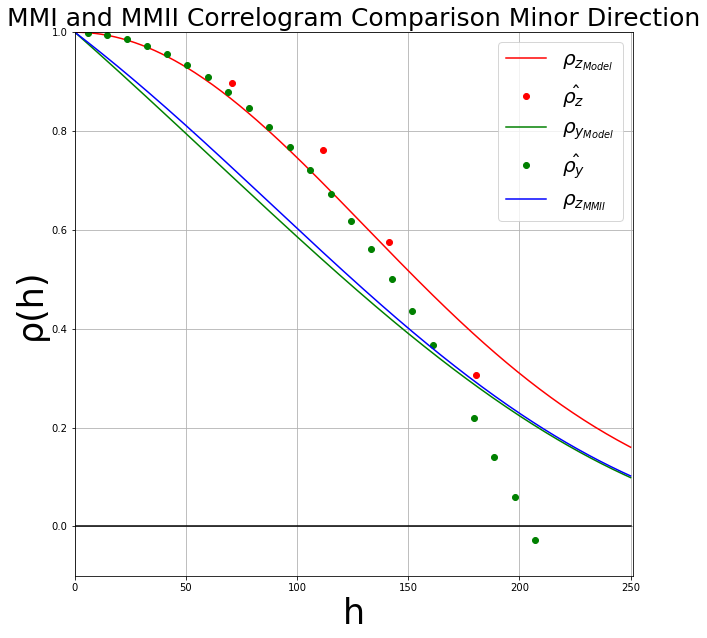

In [427]:
varg_type = 2  # See Correlogram Functions : 2 = Major Direction

a_min_mesh = np.linspace(250,350,11)
a_max_mesh = np.linspace(200,300,11)


for Dir in Directions:
    for a_min,a_max in zip()
    for h in range(0, LENGTH + 1):
        cy[h] = C_Y(np.matrix(h), np.matrix(h), varg_type)
        cz_True[h] = C_Z(np.matrix(h), np.matrix(h), varg_type)
        cz[h] = C_Z_MM2(np.matrix(h), np.matrix(h), varg_type, corr)
        cr[h] = C_r(np.matrix(h), np.matrix(h), varg_type)
        H[h] = h # matrice des valeurs de lag
    MM_vargs = [cz_True, cy, cz]
    fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    for i in range(0, 3):
        axes.plot(H, MM_vargs[i], color=colors[i], label=labels_MM[i])
        if (i + 1) < 3:
            var = locals()["varcalcfl_{}".format(i + 1)]
            axes.plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                "ro",
                color=colors[i],
                label=labels_1[i],
            )

    axes.plot(H, ones, color="Black")
    axes.grid()
    plt.xlim(0, LENGTH + 1)
    plt.ylim(-0.1, 1)
    plt.ylabel("\u03C1(h)", size=35)
    plt.xlabel("h", size=35)
    plt.title(
        "MMI and MMII Correlogram Comparison {} Direction".format(Dir),
        size=25,
    )
    axes.legend(loc="best", prop={"size": 20})
    #plt.savefig("MM1_MM2_var_{}".format(Dir), bbox_inches="tight", dpi=300)
    varg_type = varg_type + 1

# ANNEXE

# Co-Kriging

## Using pyKriging

### Exemple

In [43]:
from pyKriging import coKriging

def cheap(X) :
    
    A = 0.5
    B = 10
    C = -5
    D = 0
    
    print(X)
    print(((X+D)*6-2))
    
    return A*np.power((X*6-2), 2 ) * np.sin(((X+D)*6-2)*2) + ((X+D)-0.5)*B+5

def expensive(X):
    return np.power((X*6-2),2)*np.sin((X*6-2)*2)


Xe = np.array([0, 0.4, 0.6, 1])
Xc = np.array([0.1,0.2,0.3,0.5,0.7,0.8,0.9,0,0.4,0.6,1])

yc = cheap(Xc)
ye = expensive(Xe)

[0.1 0.2 0.3 0.5 0.7 0.8 0.9 0.  0.4 0.6 1. ]
[-1.4 -0.8 -0.2  1.   2.2  2.8  3.4 -2.   0.4  1.6  4. ]


In [49]:
ck = coKriging.coKriging(Xc,yc,Xe,ye)
ck.thetac = np.array([1.2073])
print(ck.Xc)
ck.updateData()

Found this value in XE!!
Found this value in XE!!
Found this value in XE!!
Found this value in XE!!
here1
[[0.9]
 [0.8]
 [0.7]
 [0.5]
 [0.3]
 [0.2]
 [0.1]
 [0. ]
 [0.4]
 [0.6]
 [1. ]]


## Using OpenMDAO

### Exemple

In [50]:
from openmdao.surrogate_models.multifi_cokriging import MultiFiCoKriging

In [ ]:
# Xe : DOE for expensive code (nested in Xc)
# Xc : DOE for cheap code
# ye : expensive response
# yc : cheap response

In [54]:
Xe = np.array([[0],[0.4],[1]])
Xc = np.vstack((np.array([[0.1],[0.2],[0.3],[0.5],[0.6],[0.7],[0.8],[0.9]]),Xe))
ye = ((Xe*6-2)**2)*np.sin((Xe*6-2)*2)
yc = 0.5*((Xc*6-2)**2)*np.sin((Xc*6-2)*2)+(Xc-0.5)*10. - 5

array([[-9.32828839],
       [-8.31986355],
       [-7.00778837],
       [-4.54535129],
       [-4.0747189 ],
       [-5.30287702],
       [-4.47456522],
       [ 1.85597517],
       [-8.48639501],
       [-5.94261151],
       [ 7.91486597]])

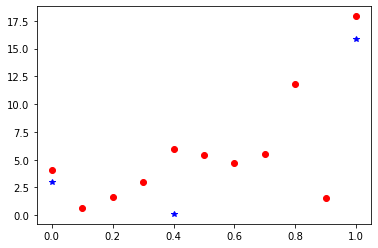

In [59]:
plt.plot(Xe,ye,'b*')
plt.plot(Xc,yc,'ro')

##### Theta :
(double, array_like or list or None) Value of correlation parameters if they are known; no optimization is run. Default is None, so that optimization is run. if double: value is replicated for all features and all levels. if array_like: an array with shape (n_features, ) for isotropic calculation. It is replicated for all levels. if list: a list of nlevel arrays specifying value for each level
##### Theta0 : 
(double, array_like or list or None) Starting point for the maximum likelihood estimation of the best set of parameters. Default is None and meaning use of the default 0.5*np.ones(n_features) if double: value is replicated for all features and all levels. if array_like: an array with shape (n_features, ) for isotropic calculation. It is replicated for all levels. if list: a list of nlevel arrays specifying value for each level
##### ThetaL :
(double, array_like or list or None) Lower bound on the autocorrelation parameters for maximum likelihood estimation. Default is None meaning use of the default 1e-5*np.ones(n_features). if double: value is replicated for all features and all levels. if array_like: An array with shape matching theta0’s. It is replicated for all levels of code. if list: a list of nlevel arrays specifying value for each level
##### ThetaU :
(double, array_like or list or None) Upper bound on the autocorrelation parameters for maximum likelihood estimation. Default is None meaning use of default value 50*np.ones(n_features). if double: value is replicated for all features and all levels. if array_like: An array with shape matching theta0’s. It is replicated for all levels of code. if list: a list of nlevel arrays specifying value for each level

In [143]:
model = MultiFiCoKriging(theta0=1, thetaL=1e-5, thetaU=50.)
model.fit([Xc, Xe], [yc, ye])
model_basique = MultiFiCoKriging()
model_basique.fit([Xc, Xe], [yc, ye])

In [78]:
# Prediction on x=0.05
np.abs(float(model.predict([0.05])[0])- ((0.05*6-2)**2)*np.sin((0.05*6-2)*2))

0.9733619337183353

In [82]:
model.predict([0.05])[0]

array([[1.71187572]])

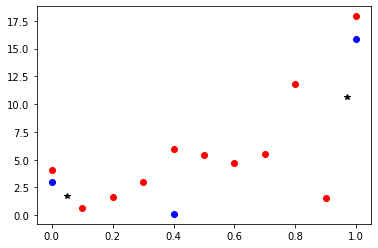

In [110]:
plt.plot(Xe,ye,'bo')
plt.plot(Xc,yc,'ro')
plt.plot(xx,model.predict([0.05])[0],"k*")
plt.plot(0.97,model.predict([0.97])[0],"k*")

In [145]:
X = np.linspace(0,1,101)

def get_model_prediction(X,model = model) :
    model_prediction = []
    for value in X : 
        model_prediction.append(model.predict([float(value)])[0][0][0])
        
    return model_prediction

In [147]:
model_prediction = get_model_prediction(X)
model_basique_prediction = get_model_prediction(X,model_basique)

In [137]:
model.predict([float(value)])[0][0][0]

15.829731542354887

In [132]:
model_prediction[0][0][0]

3.0272095134739456

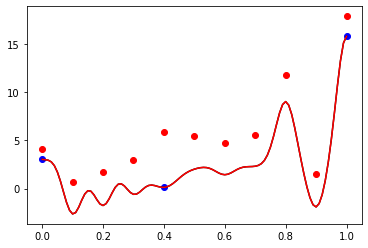

In [149]:
plt.plot(Xe,ye,'bo')
plt.plot(Xc,yc,'ro')
plt.plot(X,model_prediction,'k')
plt.plot(X,model_basique_prediction,'r')


## Appliqué à la PT° et T°

In [ ]:
#dict_sensor_calibration = {}
for sensor in dict_sensor : 
    x = [(times.minute + times.hour * 60) for times in dict_rms[sensor]["Time"]] # conversion Timestamp to minutes
    y = dict_rms[sensor]["RMS"]
    start_day = dict_rms[sensor]["Time"][0]
    end_day = dict_rms[sensor]["Time"][-1]

    f = interp1d(x,y,kind = "cubic")
    xnew = [(times.minute + times.hour * 60) for times in pd.date_range(start_day,end_day,freq = "15min")]
    # création d'une valeur toutes les 15 minutes
    ynew = f(xnew)
    dict_sensor_calibration[sensor] = {"Interpolate_time" : pd.date_range(start_day,end_day,freq = "15min"),
                                  "Interpolate_value" : ynew }

In [188]:
dict_temp_sensor["S1"]["Time"].iloc[0].minute

0

In [ ]:
# Xt : Température de la sonde au sol : cheap response
# Xp : Pseudo-Température du signal IR : expensive response

In [215]:
def get_model_prediction(X,model = model) :
    model_prediction = []
    for value in X : 
        model_prediction.append(model.predict([float(value)])[0][0][0])
        
    return model_prediction

In [245]:
dict_rms[sensor]["Time"][::2]

[Timestamp('2019-04-14 07:00:00'),
 Timestamp('2019-04-14 08:30:00'),
 Timestamp('2019-04-14 10:30:00'),
 Timestamp('2019-04-14 12:30:00'),
 Timestamp('2019-04-14 16:00:00')]

<ipython-input-252-e4d9eeb3501b>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(time.hour)+':'+str(time.minute) for time in dict_rms[sensor]["Time"]])
<ipython-input-252-e4d9eeb3501b>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(time.hour)+':'+str(time.minute) for time in dict_rms[sensor]["Time"]])
<ipython-input-252-e4d9eeb3501b>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(time.hour)+':'+str(time.minute) for time in dict_rms[sensor]["Time"]])
<ipython-input-252-e4d9eeb3501b>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(time.hour)+':'+str(time.minute) for time in dict_rms[sensor]["Time"]])
<ipython-input-252-e4d9eeb3501b>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(time.hour)+':'+str(time.mi

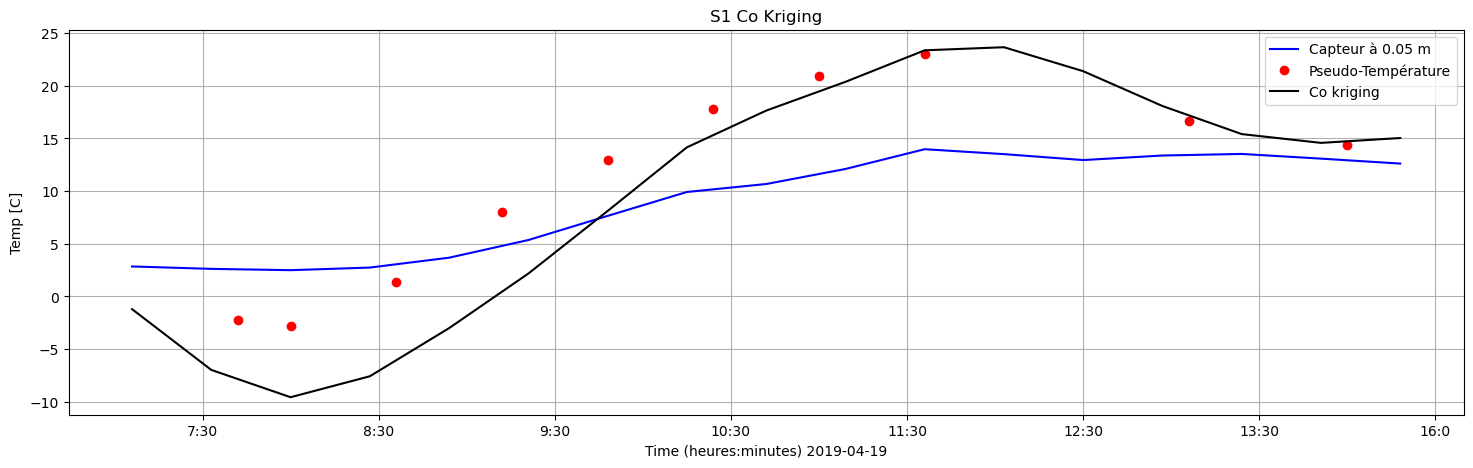

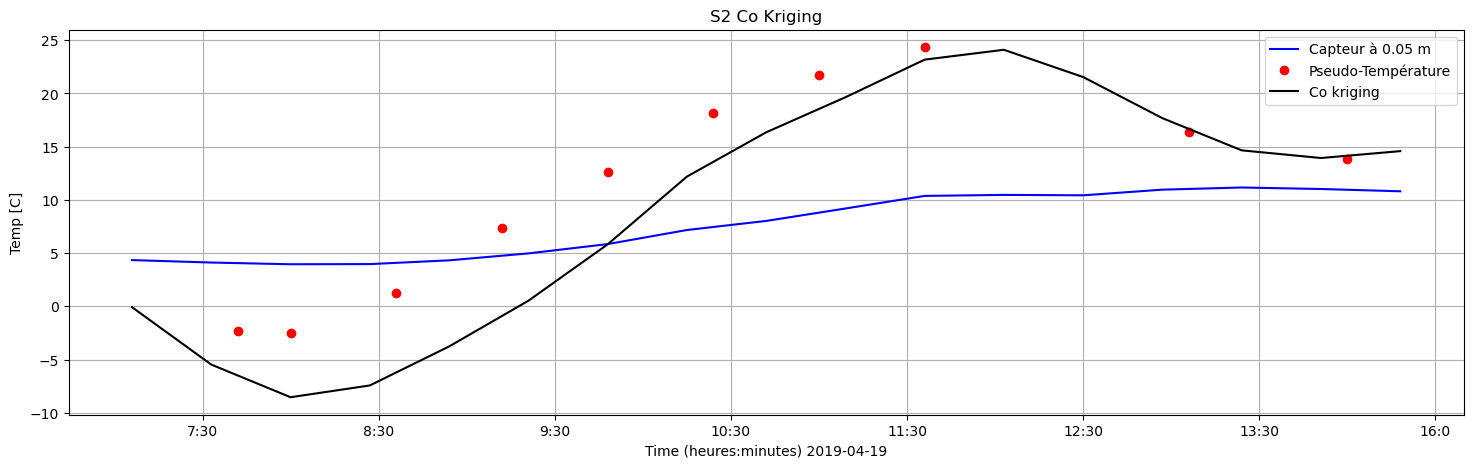

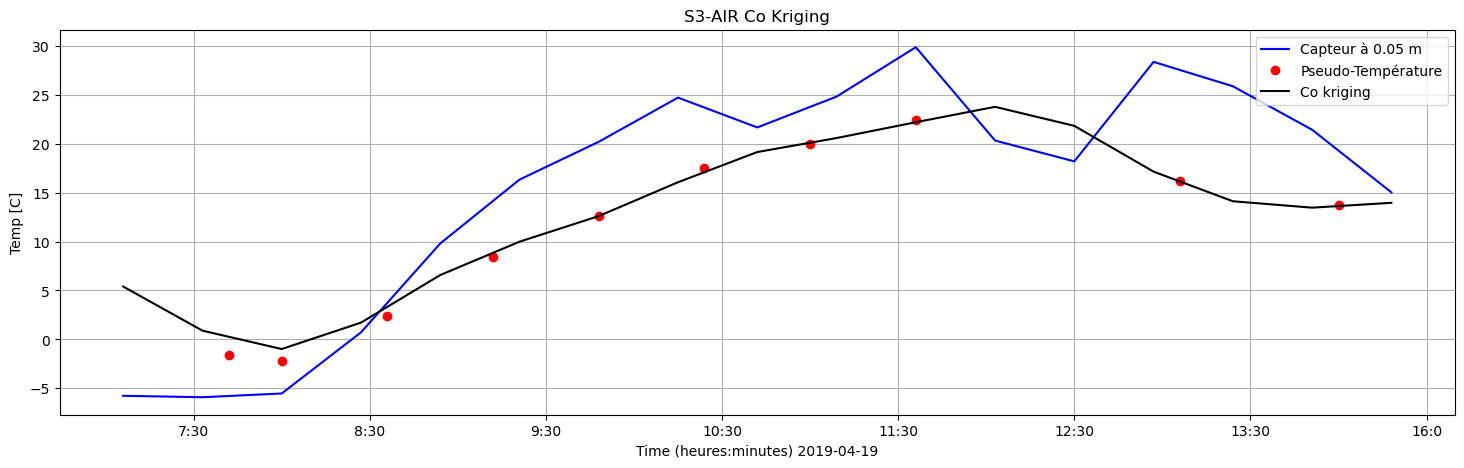

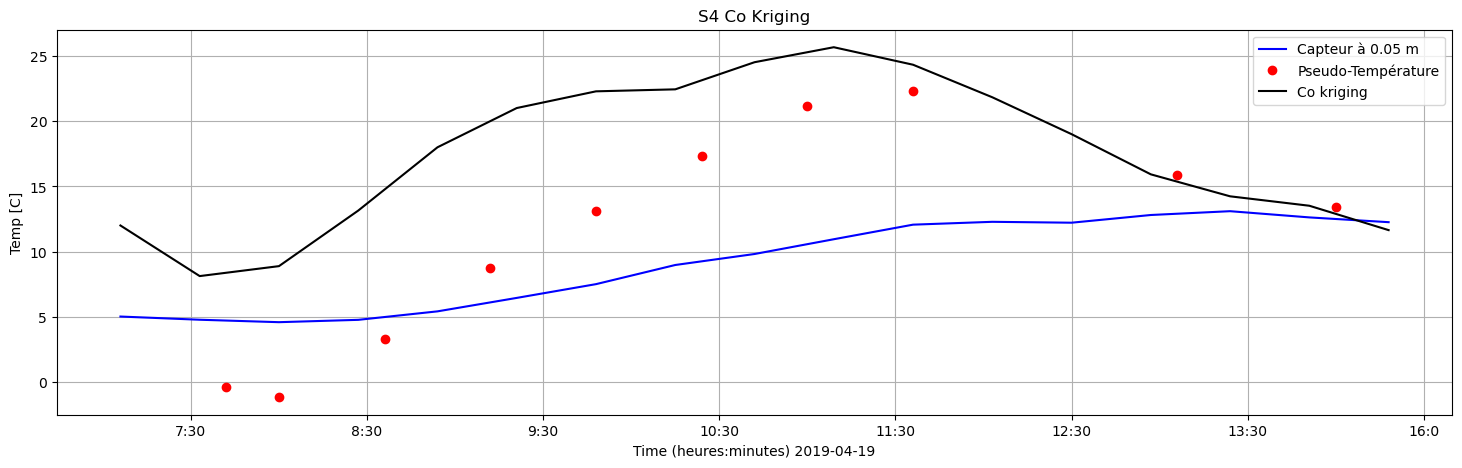

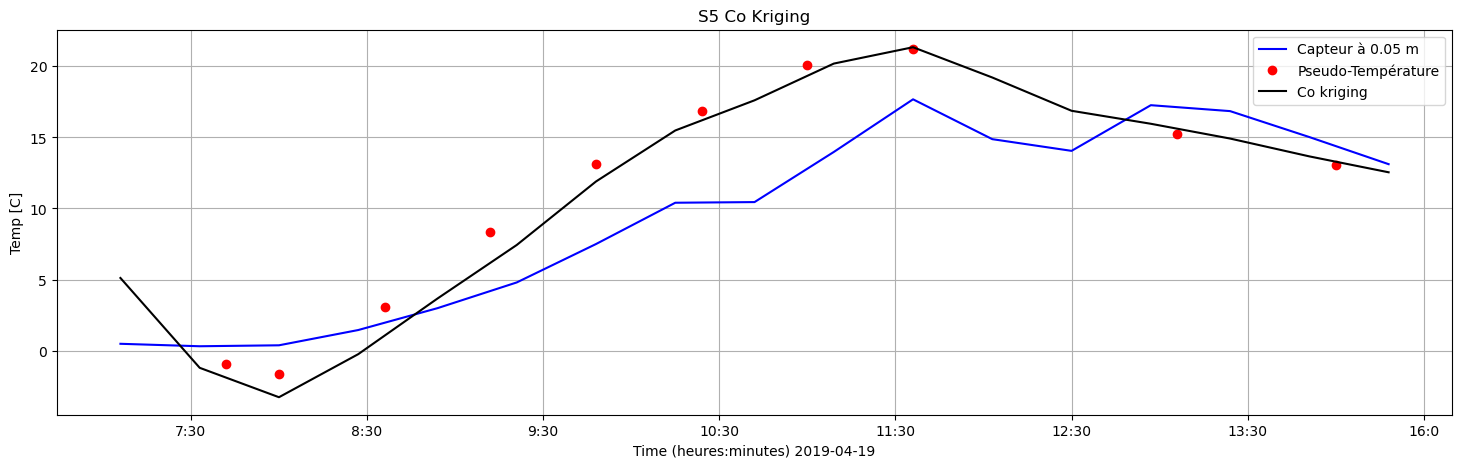

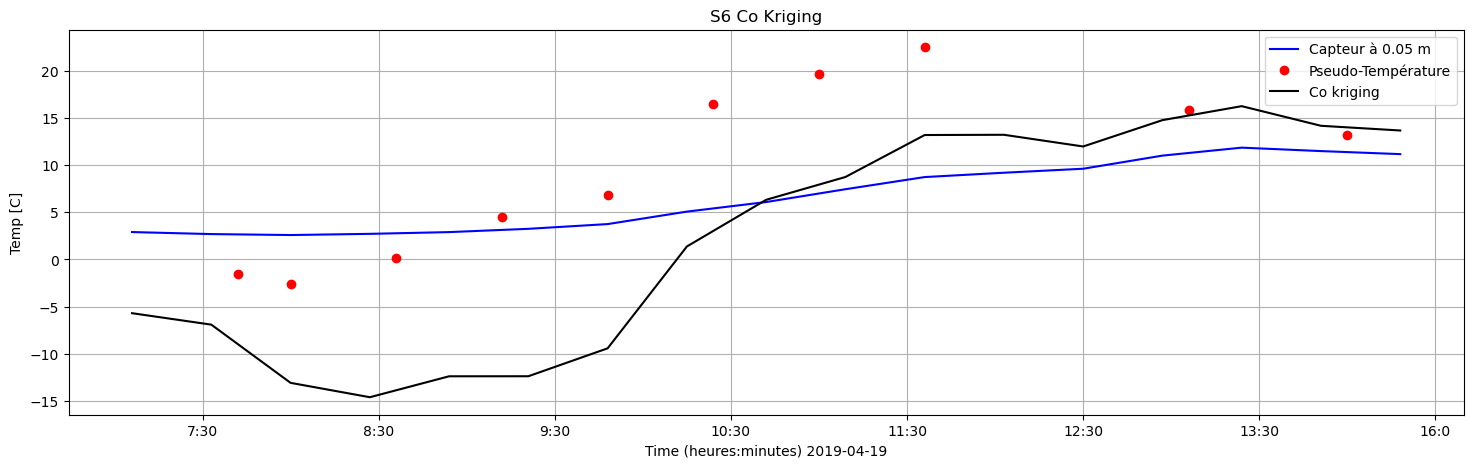

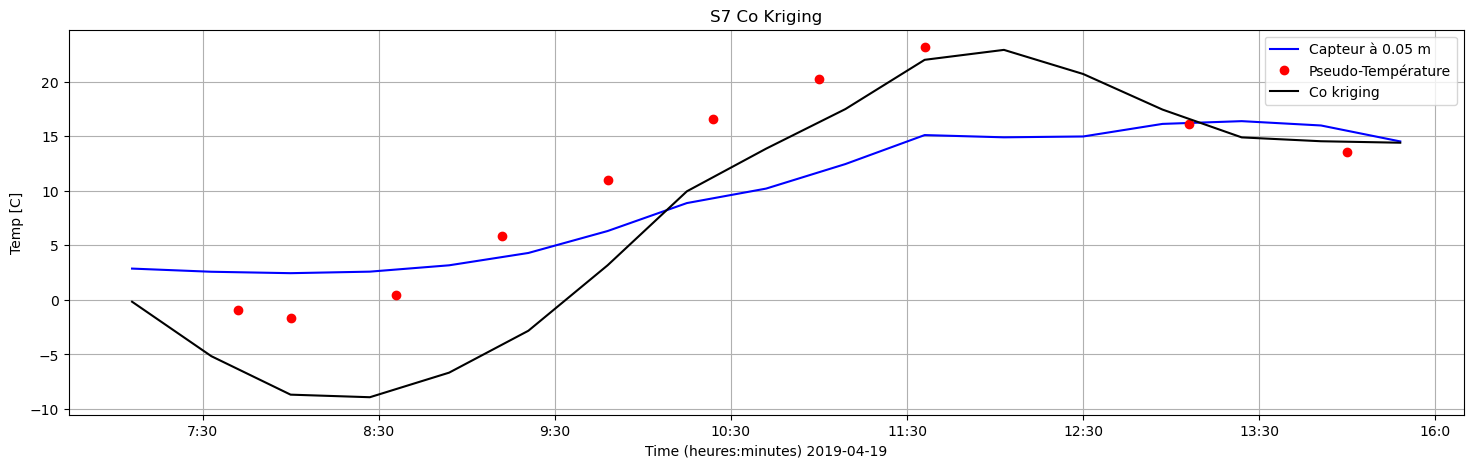

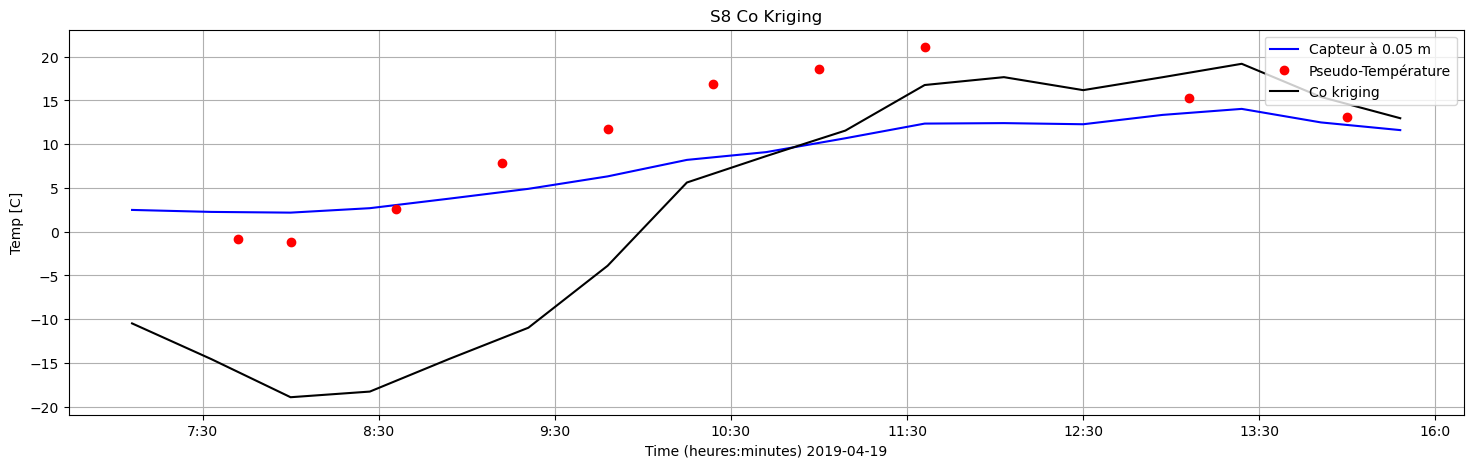

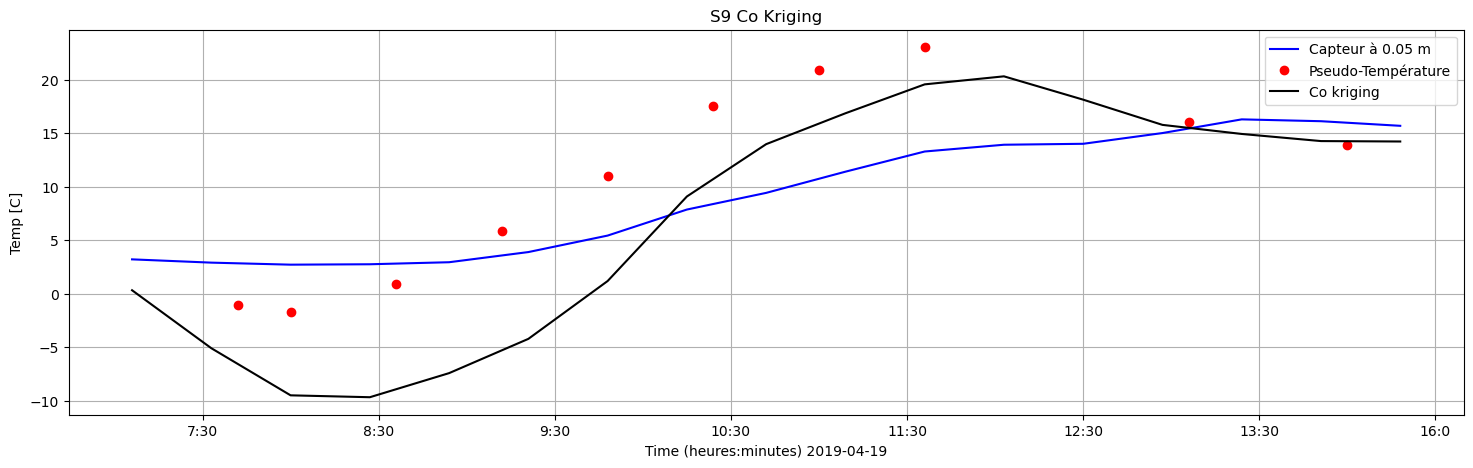

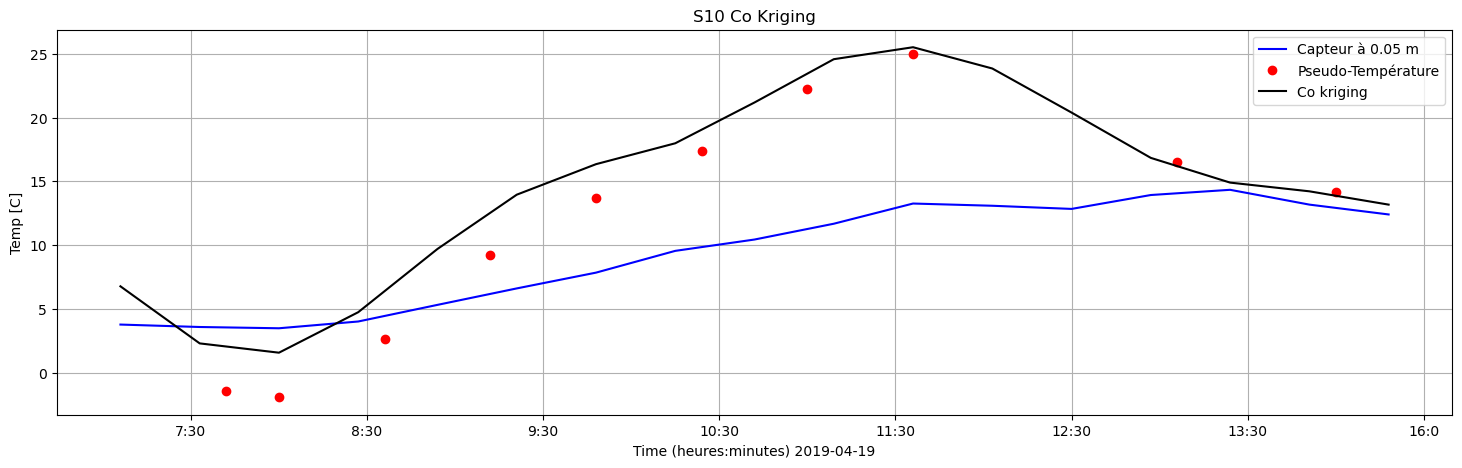

In [252]:
for sensor in dict_sensor :
    Xt = np.array([([times.minute + times.hour * 60]) for times in dict_temp_sensor[sensor]["Time"][::3]] )
    Xp = np.array([([times.minute + times.hour * 60]) for times in dict_rms[sensor]["Time"]] )
    
    Yt = np.array([ [temp] for temp in dict_temp_sensor[sensor]['T4'][::3]])
    Yp = np.array([ [temp] for temp in dict_rms[sensor]['pseudo_temp']]) 
    model_basique = MultiFiCoKriging(normalize = True)
    model_basique.fit([Xt, Xp], [Yt, Yp])
    model_prediction = get_model_prediction(Xt,model_basique)
    
    fig,ax = plt.subplots(figsize = (18,5))
    ax.plot(Xt,Yt,'b', label = "Capteur à 0.05 m ")
    ax.plot(Xp,Yp,'ro', label = "Pseudo-Température")
    ax.plot(Xt,model_prediction,'k', label = "Co kriging")
    ax.set_title(sensor + ' Co Kriging')
    ax.set_xticklabels([str(time.hour)+':'+str(time.minute) for time in dict_rms[sensor]["Time"]])
    ax.set_xlabel('Time (heures:minutes)' + ' 2019-04-19' )
    ax.set_ylabel('Temp [C]')
    ax.grid()
    ax.legend(loc='upper right')
    modif = "_dif"
    #fileout =  "C:/Users/Alexandre/Desktop/Cours/Stage/Temp_vs_IR/2m/CK/"+ str(sensor)+modif+".png"
    #fig.savefig(fileout,bbox_inches = 'tight')

In [222]:
model_basique = MultiFiCoKriging(theta0=1, thetaL=1e-5, thetaU=50.,normalize = True)
model_basique.fit([Xt, Xp], [Yt, Yp])

In [223]:
model_prediction = get_model_prediction(Xt,model_basique)

In [ ]:
Mask_1 = varcalcfl_1["Lag Distance"] != 0 # Mask sur les valeurs différentes de 0 
varcalcfl_1.loc[Mask_1]
varcalcfl_1 = varcalcfl_1.loc[Mask_1]
varcalcfl_1 = varcalcfl_1.drop_duplicates(subset = ["Lag Distance"]) # Supprime les doublons !! 

In [140]:
lag_size = 50 #en mètre
patch_size = 500 # en mètre
lag = int(1/lag_size * (patch_size/2))
#x_min = df["x"].min() ; x_max = df["x"].max() ; y_min = df["y"].min() ; y_max = df["y"].max()
#min_RGB = df["band RGB"].min() ; max_RGB = df["band RGB"].max() 

vmap,nmap = geostats.varmapv(datafl_sec,"X","Y","Secondary",tmin=-999,tmax=999,nxlag=lag,nylag=lag,
                             dxlag=lag_size,dylag=lag_size,minnp=1,isill=1)


KeyboardInterrupt: 

AttributeError: 'PathCollection' object has no property 'verts'

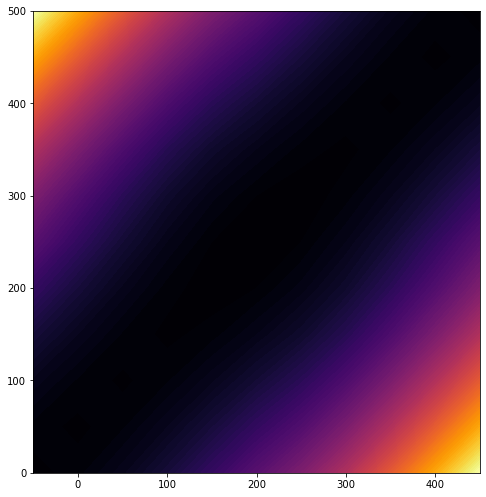

In [139]:
fig2,ax2 = plt.subplots(1,1,figsize=(8,8.5))
plt.rc('axes', titlesize=18)    # legend fontsize
vmap = vmap
nmap = nmap
df = datafl
x_min = df["X"].min() ; x_max = df["X"].max() ; y_min = df["Y"].min() ; y_max = df["Y"].max()
cmap = plt.cm.inferno

GSLIB.pixelplt_st(vmap,x_min-lag_size,x_max+lag_size,y_min-lag_size,y_max+lag_size,lag_size,vmap.min(),vmap.max(),
                  'Nscore Variogram Map ','X(m)','Y(m)','Nscore Variogram',cmap)


plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.show()

print('The shape of the output is ' + str(vmap.shape))